In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
from matplotlib import pylab as plt
from statsmodels.graphics.gofplots import qqplot
from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import layers, regularizers, Sequential
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics         import mean_absolute_error

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)
InteractiveShell.ast_node_interactivity = 'all'

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
set_seed()

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)
plt.style.use('fivethirtyeight')
pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 25)
pd.set_option("display.max_rows", 20)

print("setup-complete!")

setup-complete!


In [2]:
raw = "nyc-taxi-trip-duration/train.csv"
taxi_data = pd.read_csv(raw, low_memory=False)

In [3]:
taxi_data 

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [4]:
taxi_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
categorical = taxi_data.select_dtypes(exclude=[np.number]).columns
for cat_col in categorical:
    print(f"{cat_col} : {taxi_data[cat_col].nunique()} uniqueness vaiables(s)")

id : 1458644 uniqueness vaiables(s)
pickup_datetime : 1380222 uniqueness vaiables(s)
dropoff_datetime : 1380377 uniqueness vaiables(s)
store_and_fwd_flag : 2 uniqueness vaiables(s)


In [6]:
numeric = taxi_data.select_dtypes(include=[np.number]).columns
for num_col in numeric:
    print(f"{num_col} : {taxi_data[num_col].nunique()} uniqueness variable(s)")

vendor_id : 2 uniqueness variable(s)
passenger_count : 10 uniqueness variable(s)
pickup_longitude : 23047 uniqueness variable(s)
pickup_latitude : 45245 uniqueness variable(s)
dropoff_longitude : 33821 uniqueness variable(s)
dropoff_latitude : 62519 uniqueness variable(s)
trip_duration : 7417 uniqueness variable(s)


In [7]:
missing_values_count = taxi_data.isnull().sum()
missing_values_count[:10]

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [11]:
train = pd.read_csv('nyc-taxi-trip-duration/train.csv')
test = pd.read_csv('nyc-taxi-trip-duration/test.csv')

In [12]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

In [14]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

(array([2.58040e+04, 1.00812e+05, 1.57814e+05, 1.70336e+05, 1.60142e+05,
        1.41426e+05, 1.20793e+05, 1.02025e+05, 8.41640e+04, 6.88180e+04,
        5.73440e+04, 4.61170e+04, 3.77930e+04, 3.10910e+04, 2.48060e+04,
        2.05270e+04, 1.68120e+04, 1.37900e+04, 1.13630e+04, 9.27200e+03,
        7.92600e+03, 6.66100e+03, 5.74200e+03, 4.77100e+03, 4.13700e+03,
        3.60300e+03, 3.11400e+03, 2.56300e+03, 2.31200e+03, 1.92300e+03,
        1.68900e+03, 1.49100e+03, 1.29800e+03, 1.09000e+03, 9.31000e+02,
        8.46000e+02, 7.33000e+02, 6.02000e+02, 5.65000e+02, 4.96000e+02,
        4.35000e+02, 3.85000e+02, 3.01000e+02, 2.56000e+02, 2.14000e+02,
        1.86000e+02, 1.80000e+02, 1.31000e+02, 1.40000e+02, 9.60000e+01,
        8.70000e+01, 8.90000e+01, 5.70000e+01, 5.20000e+01, 3.50000e+01,
        4.00000e+01, 3.90000e+01, 4.10000e+01, 1.90000e+01, 2.10000e+01,
        2.20000e+01, 1.50000e+01, 7.00000e+00, 1.10000e+01, 1.30000e+01,
        1.20000e+01, 8.00000e+00, 6.00000e+00, 7.00

Text(0.5, 0, 'trip_duration')

Text(0, 0.5, 'number of train records')

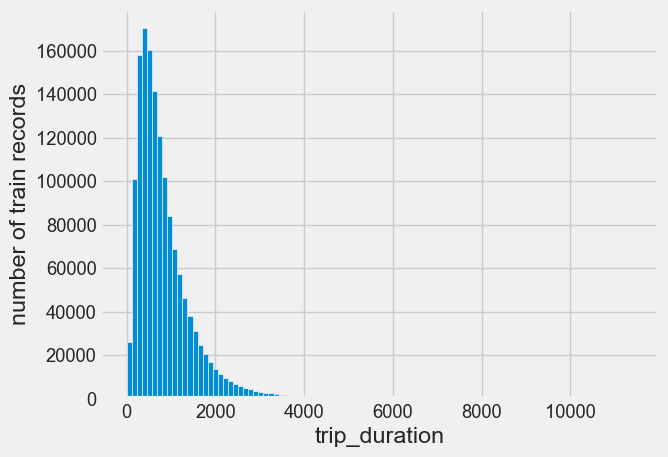

In [16]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

(array([3.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7700e+02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1800e+02, 0.0000e+00,
        3.1700e+02, 0.0000e+00, 2.8400e+02, 0.0000e+00, 1.9200e+02,
        0.0000e+00, 2.1800e+02, 2.0600e+02, 2.3900e+02, 1.8200e+02,
        1.6400e+02, 1.5200e+02, 1.6200e+02, 1.7600e+02, 2.7400e+02,
        1.4900e+02, 2.7800e+02, 2.4900e+02, 2.4700e+02, 2.8000e+02,
        3.6100e+02, 2.3200e+02, 3.8100e+02, 3.6000e+02, 4.4700e+02,
        4.6700e+02, 5.0000e+02, 5.2700e+02, 7.2000e+02, 8.3200e+02,
        1.0570e+03, 1.2900e+03, 1.6730e+03, 1.9840e+03, 3.0730e+03,
        3.0780e+03, 4.5250e+03, 5.8570e+03, 6.5660e+03, 8.9460e+03,
        1.0340e+04, 1.3532e+04, 1.5844e+04, 1.9513e+04, 2.2611e+04,
        2.6376e+04, 3.1087e+04, 3.5440e+04, 4.0591e+04, 4.2909e+04,
        4.9700e+04, 5.2370e+04, 5.7609e+04, 6.0396e+04, 6.2454e+04,
        6.6228e+04, 6.8001e+04, 6.8058e+04, 6.8343e+04, 6.7282e+04,
        6.5208e+04, 6.1566e+04, 5.8047e+04, 5.39

Text(0.5, 0, 'log(trip_duration)')

Text(0, 0.5, 'number of train records')

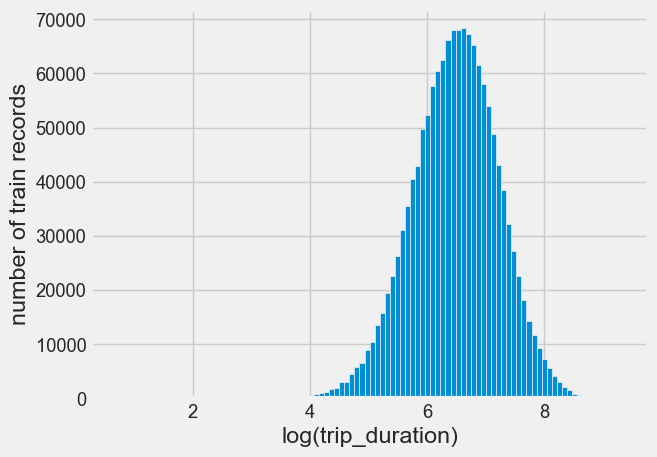

<Axes: xlabel='log_trip_duration', ylabel='Density'>

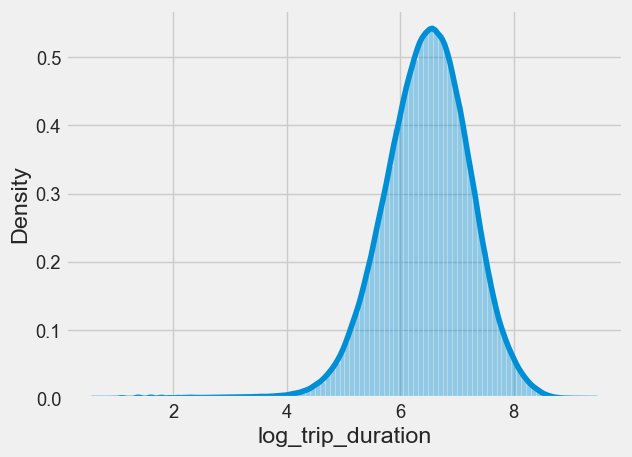

In [ ]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

Text(0.5, 1.0, 'Trips over Time.')

Text(0, 0.5, 'Trips')

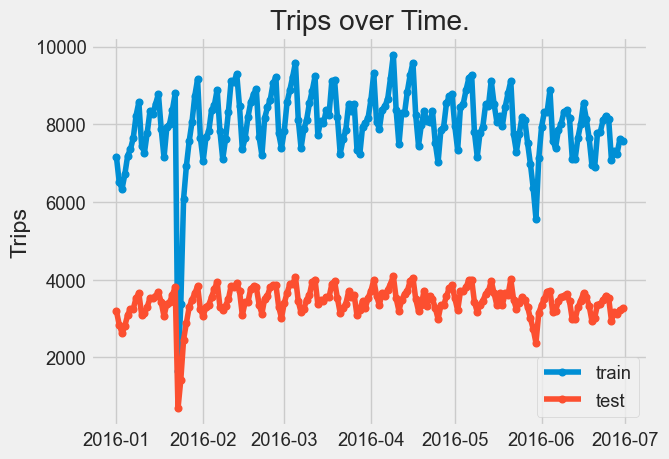

In [18]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

Text(0.5, 0.98, 'Train and test area complete overlap.')

Text(0, 0.5, 'latitude')

Text(0.5, 0, 'longitude')

Text(0.5, 0, 'longitude')

(40.63, 40.85)

(-74.03, -73.75)

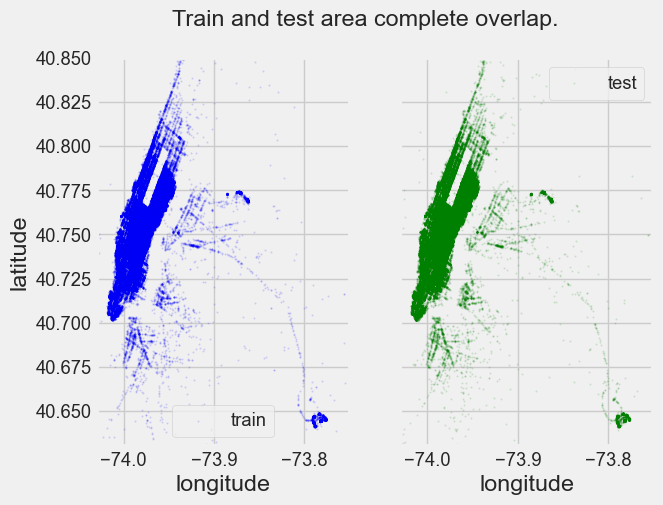

In [22]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [10]:
taxi_data["vendor_id"].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

<Axes: xlabel='passenger_count'>

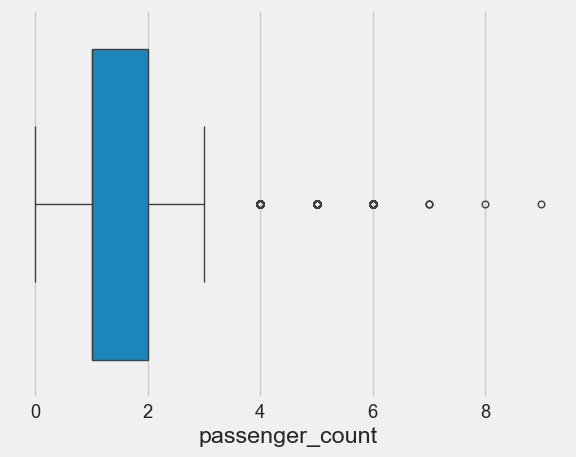

In [11]:
sns.boxplot(data=taxi_data,x="passenger_count")

In [28]:
taxi_data["passenger_count"].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

In [29]:
print(taxi_data.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [30]:
taxi_data["passenger_count"].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

<Axes: xlabel='pickup_longitude'>

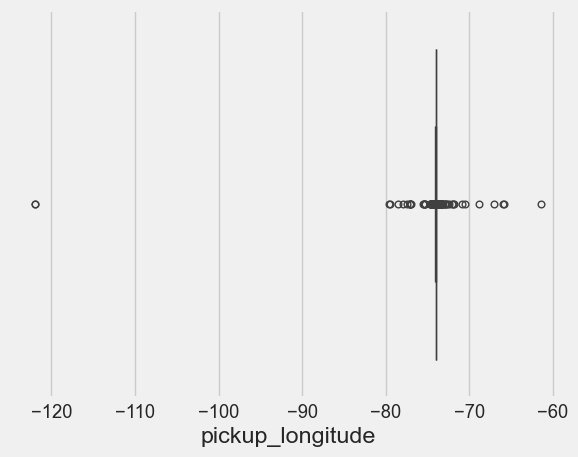

In [31]:
sns.boxplot(data=taxi_data,x="pickup_longitude")

<Axes: xlabel='pickup_latitude'>

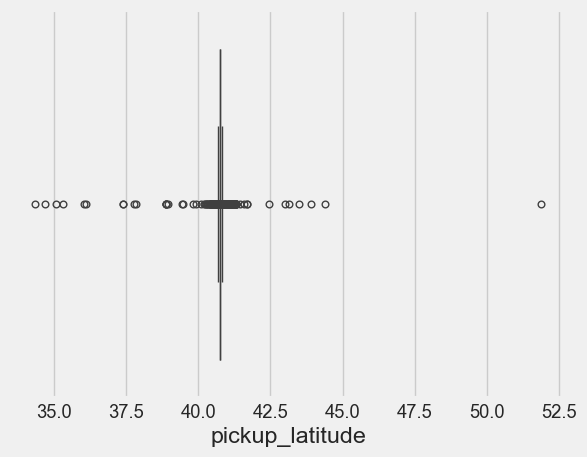

In [32]:
sns.boxplot(data=taxi_data,x="pickup_latitude")

<Axes: xlabel='vendor_id'>

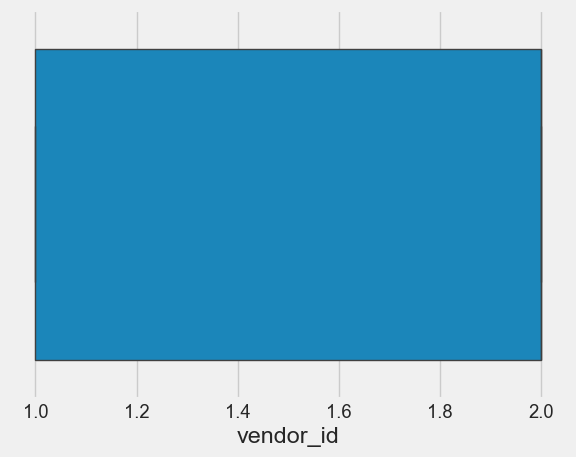

In [33]:
sns.boxplot(taxi_data,x="vendor_id")

<Axes: xlabel='vendor_id', ylabel='Count'>

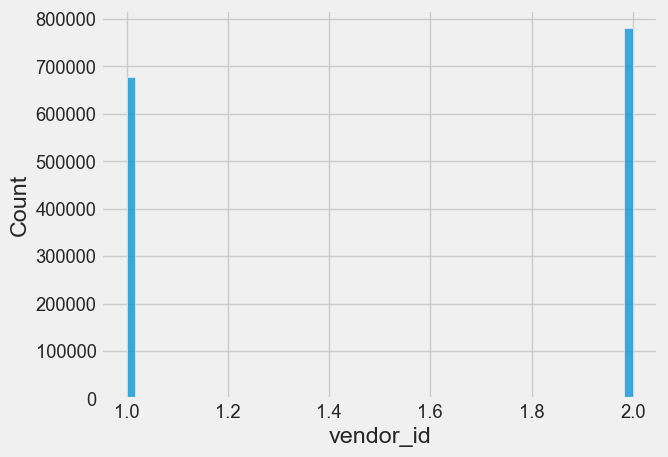

In [34]:
sns.histplot(taxi_data,x="vendor_id")

<Axes: xlabel='passenger_count', ylabel='Count'>

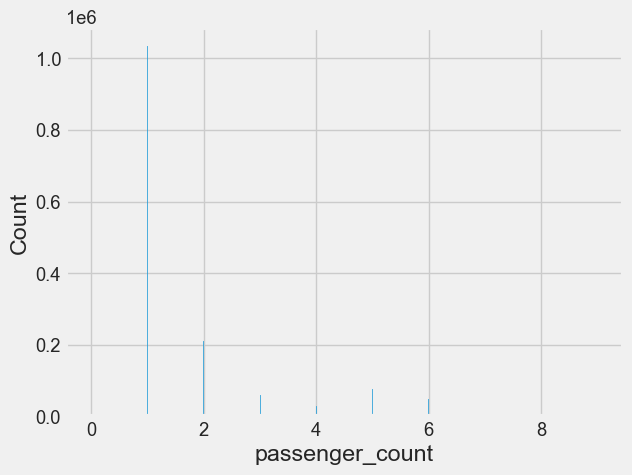

In [35]:
sns.histplot(taxi_data,x="passenger_count")

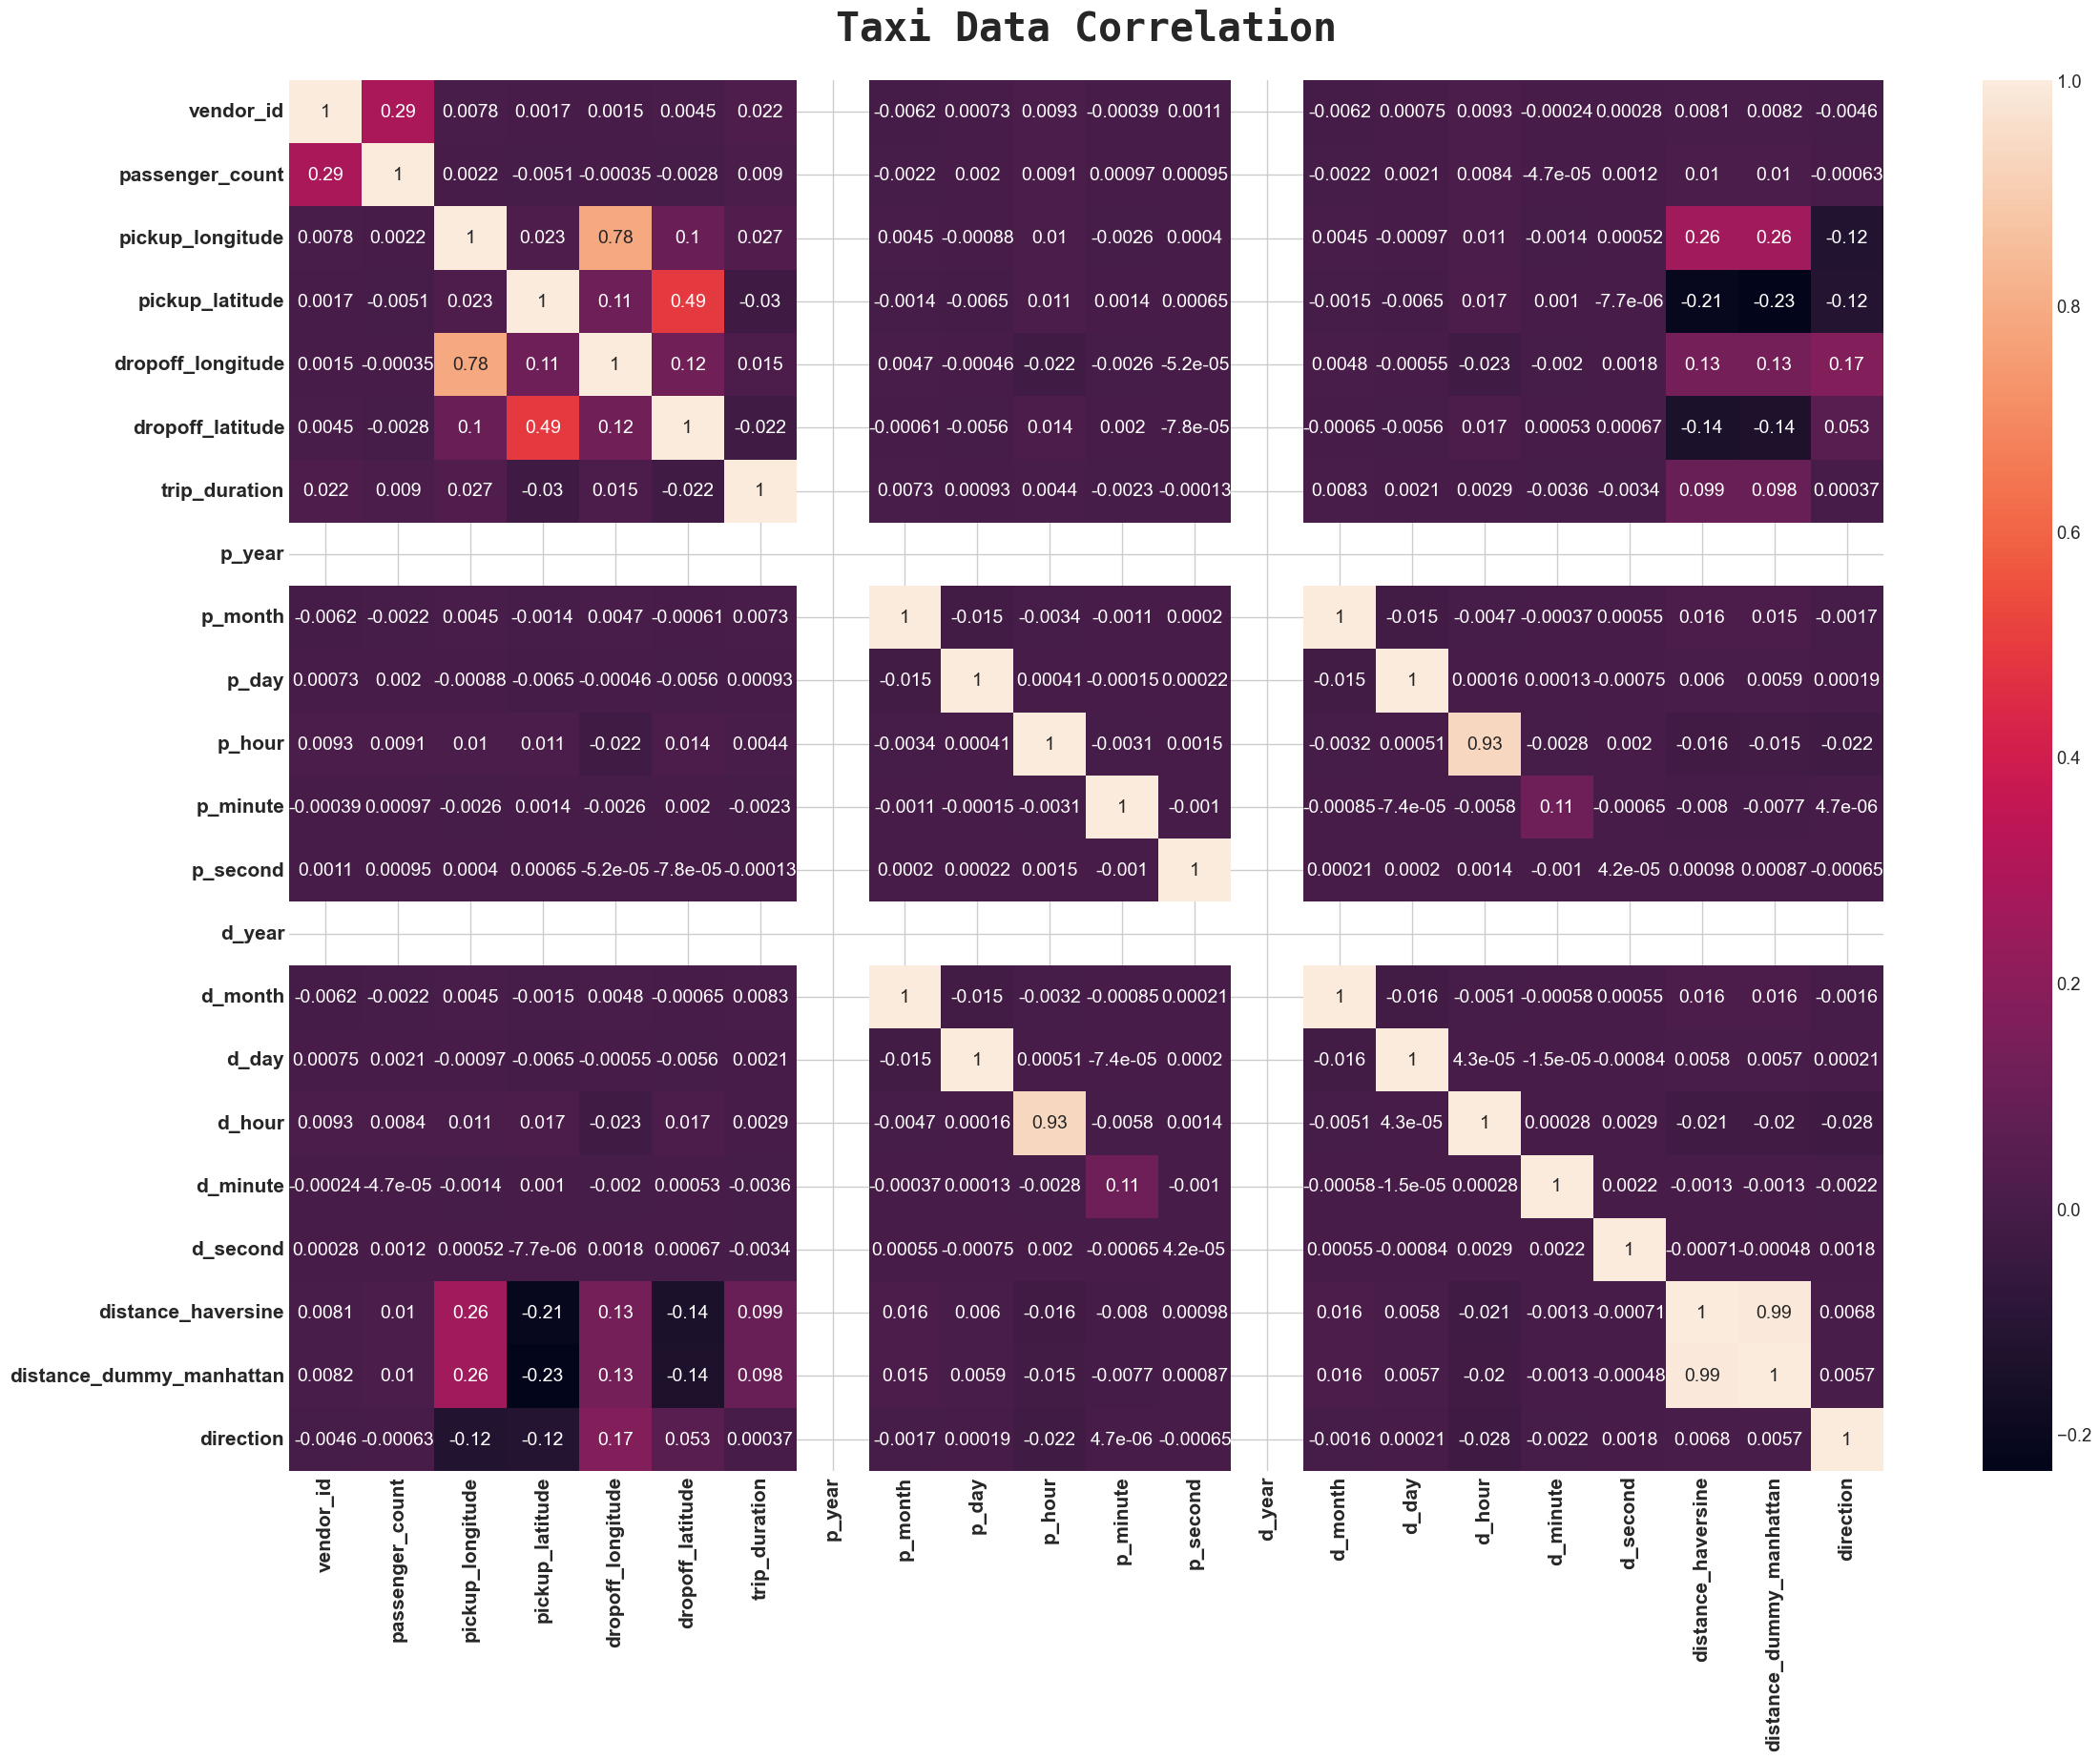

In [103]:
sns.set_style("whitegrid")
plt.figure(figsize=(24, 18))
numeric_data = taxi_data.select_dtypes(include='number')
sns.heatmap(numeric_data.corr(), annot=True)
plt.title("Taxi Data Correlation", weight="bold", fontsize=30, fontname="monospace", pad=30)
plt.xticks(weight="bold", fontsize=15)
plt.yticks(weight="bold", fontsize=15);

In [37]:
(numeric_data.corr()["trip_duration"] 
      .sort_values(ascending=False) 
      .to_frame() 
      .T)

,trip_duration,pickup_longitude,vendor_id,dropoff_longitude,passenger_count,dropoff_latitude,pickup_latitude
trip_duration,1.0,0.026542,0.020304,0.014678,0.008471,-0.020677,-0.029204


In [38]:
taxi_data.describe(include=[np.number]).astype("int") 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644,1458644,1458644,1458644,1458644,1458644,1458644
mean,1,1,-73,40,-73,40,959
std,0,1,0,0,0,0,5237
min,1,0,-121,34,-121,32,1
25%,1,1,-73,40,-73,40,397
50%,2,1,-73,40,-73,40,662
75%,2,2,-73,40,-73,40,1075
max,2,9,-61,51,-61,43,3526282


In [39]:
def univariate_analysis(data, color, title1, title2):
    
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, 
        nrows=1,
        figsize=(20, 6) 
    )

    sns.distplot( 
        data, 
        ax=ax1, 
        kde=True, 
        color=color 
    )
    
    ax1.set_title( 
        title1, 
        weight="bold", 
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    qqplot( 
        data, 
        ax=ax2, 
        line='s'  
    )
    
    ax2.set_title( 
        title2, 
        weight="bold", 
        fontname="monospace", 
        fontsize=25, 
        pad=30 
    )
    
    return fig 

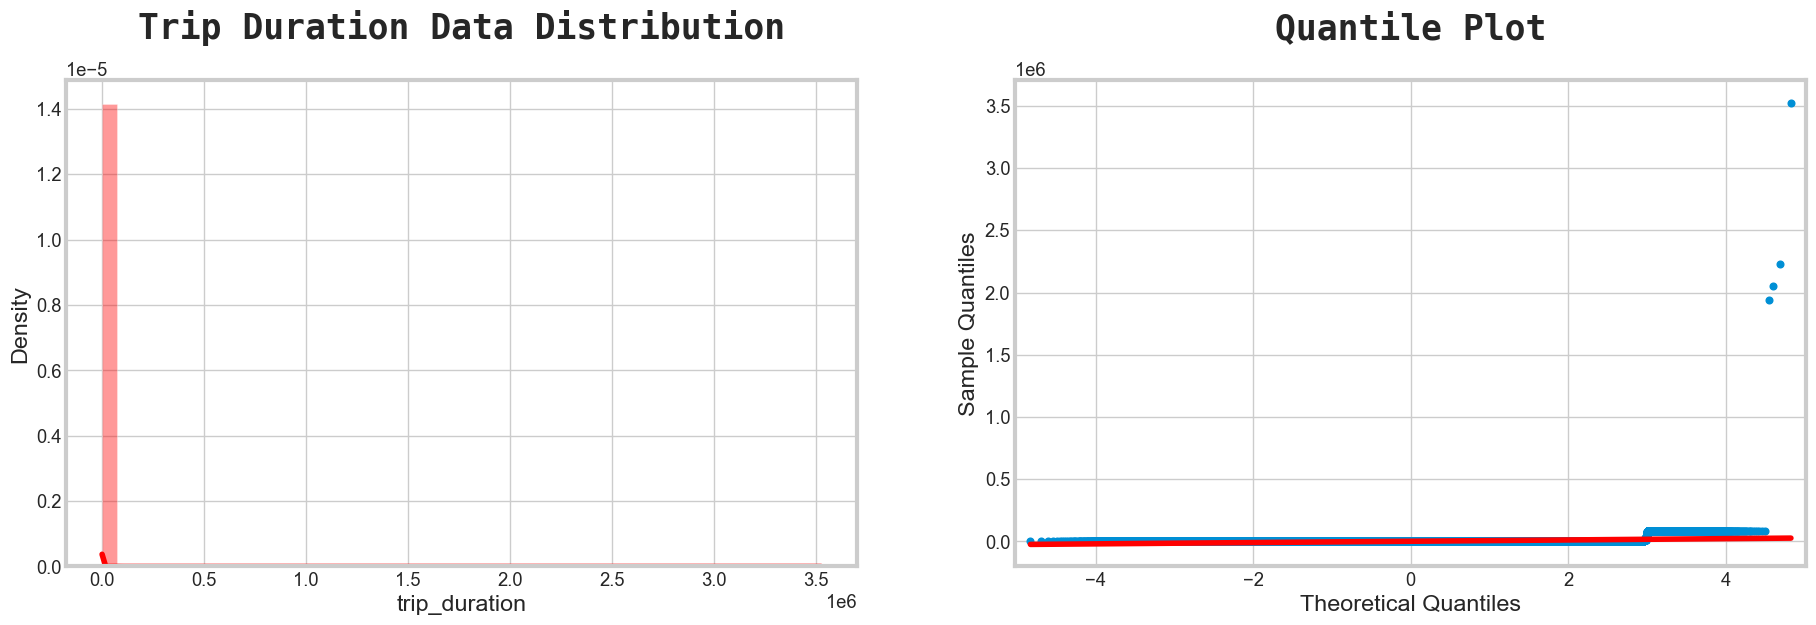

In [40]:

univariate_analysis( 
    data=taxi_data["trip_duration"], 
    color="red", 
    title1="Trip Duration Data Distribution", 
    title2="Quantile Plot"); 

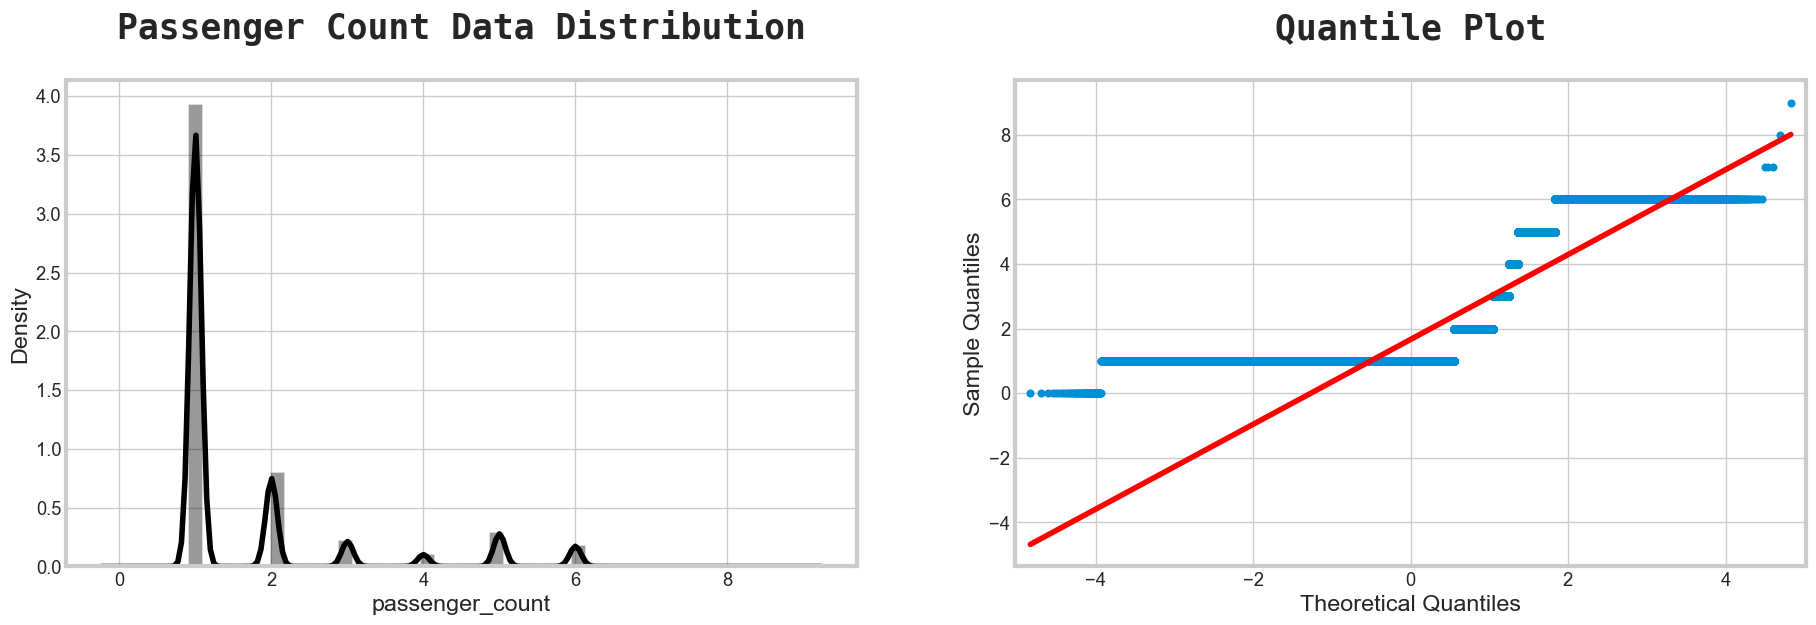

In [41]:

univariate_analysis( 
    data=taxi_data["passenger_count"], 
    color="black", 
    title1="Passenger Count Data Distribution", 
    title2="Quantile Plot"); 

In [42]:
skew_value = numeric_data.skew().sort_values(ascending=False).to_frame().head()
skew_value

,0
trip_duration,343.163944
pickup_latitude,5.489127
passenger_count,2.128094
vendor_id,-0.140144
dropoff_latitude,-20.671187


In [43]:
taxi_data[["p_ymd", "p_hms"]] = taxi_data["pickup_datetime"].str.split(" ", expand=True) 
taxi_data[["d_ymd", "d_hms"]] = taxi_data["dropoff_datetime"].str.split(" ", expand=True) 

del taxi_data["pickup_datetime"] 
del taxi_data["dropoff_datetime"] 

taxi_data[["p_year", "p_month", "p_day"]] = taxi_data["p_ymd"].str.split("-", expand=True).astype("int") 
taxi_data[["p_hour", "p_minute", "p_second"]] = taxi_data["p_hms"].str.split(":", expand=True).astype("int") 

del taxi_data["p_ymd"] 
del taxi_data["p_hms"] 

taxi_data[["d_year", "d_month", "d_day"]] = taxi_data["d_ymd"].str.split("-", expand=True).astype("int") 
taxi_data[["d_hour", "d_minute", "d_second"]] = taxi_data["d_hms"].str.split(":", expand=True).astype("int") 

del taxi_data["d_ymd"] 
del taxi_data["d_hms"] 
del taxi_data["id"] 

taxi_data.head(2) 

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,p_year,p_month,p_day,p_hour,p_minute,p_second,d_year,d_month,d_day,d_hour,d_minute,d_second
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,55,2016,3,14,17,32,30
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,35,2016,6,12,0,54,38


In [44]:
taxi_data.drop(taxi_data[taxi_data["trip_duration"] == 1939736].index, inplace = True)
taxi_data = taxi_data[taxi_data["passenger_count"]!=0]
taxi_data = taxi_data[taxi_data["passenger_count"]<=6]

In [57]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [64]:
taxi_data.loc[:, 'distance_haversine'] = haversine_array(taxi_data['pickup_latitude'].values, taxi_data['pickup_longitude'].values, taxi_data['dropoff_latitude'].values, taxi_data['dropoff_longitude'].values)

taxi_data.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(taxi_data['pickup_latitude'].values, taxi_data['pickup_longitude'].values, taxi_data['dropoff_latitude'].values, taxi_data['dropoff_longitude'].values)

taxi_data.loc[:, 'direction'] = bearing_array(taxi_data['pickup_latitude'].values, taxi_data['pickup_longitude'].values, taxi_data['dropoff_latitude'].values, taxi_data['dropoff_longitude'].values)


In [59]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,6.122493,1.498521,1.735433,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,6.498282,1.805507,2.430506,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,7.661527,6.385098,8.203575,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,6.063785,1.485498,1.661331,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,6.077642,1.188588,1.199457,179.473585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,6.658011,1.225080,1.665895,-119.059338
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,6.486161,6.049836,8.058580,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6.639876,7.824606,10.645646,-150.788492
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,5.924256,1.092564,1.521850,35.033294


In [65]:
taxi_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,p_year,p_month,p_day,p_hour,p_minute,p_second,d_year,d_month,d_day,d_hour,d_minute,d_second,distance_haversine,distance_dummy_manhattan,direction
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016,3,14,17,24,55,2016,3,14,17,32,30,1.498521,1.735433,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016,6,12,0,43,35,2016,6,12,0,54,38,1.805507,2.430506,-117.153768
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016,1,19,11,35,24,2016,1,19,12,10,48,6.385098,8.203575,-159.680165
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016,4,6,19,32,31,2016,4,6,19,39,40,1.485498,1.661331,-172.737700
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016,3,26,13,30,55,2016,3,26,13,38,10,1.188588,1.199457,179.473585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016,4,8,13,31,4,2016,4,8,13,44,2,1.225080,1.665895,-119.059338
1458640,1,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016,1,10,7,35,15,2016,1,10,7,46,10,6.049836,8.058580,25.342196
1458641,2,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016,4,22,6,57,41,2016,4,22,7,10,25,7.824606,10.645646,-150.788492
1458642,1,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016,1,5,15,56,26,2016,1,5,16,2,39,1.092564,1.521850,35.033294


In [67]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def preprocessing_data(data):
    categorical_col = ["store_and_fwd_flag"]
    numerical_col = ['vendor_id', 'passenger_count', 'pickup_longitude', 
                     'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',  
                     'p_year', 'p_month', 'p_day', 'p_hour', 'p_minute', 'p_second', 
                     'd_year', 'd_month', 'd_day', 'd_hour', 'd_minute', 'd_second',
                     'distance_haversine', 'direction']
    

    column_transformer = make_column_transformer(
        (MinMaxScaler(), numerical_col),
        (OneHotEncoder(handle_unknown="ignore"), categorical_col)
    )
    

    X = data.drop(columns=["trip_duration"])
    y = data["trip_duration"]
    

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    

    column_transformer.fit(X_train)
    

    X_train_normal = column_transformer.transform(X_train)
    X_test_normal = column_transformer.transform(X_test)
    

    X_train, X_test = tf.constant(X_train_normal, dtype=tf.float32), tf.constant(X_test_normal, dtype=tf.float32)
    

    y_train, y_test = tf.constant(y_train, dtype=tf.float32), tf.constant(y_test, dtype=tf.float32)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = preprocessing_data(taxi_data)

In [68]:

X_train.shape, X_test.shape, X_train.ndim, X_test.ndim

(TensorShape([1166862, 22]), TensorShape([291716, 22]), 2, 2)

In [69]:

y_train.shape, y_test.shape, y_train.ndim, y_test.ndim

(TensorShape([1166862]), TensorShape([291716]), 1, 1)

In [70]:

X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(tf.float32, tf.float32, tf.float32, tf.float32)

In [71]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1166862, 291716, 1166862, 291716)

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

In [97]:
set_seed()

best_model = tf.keras.Sequential([
    layers.Dense(100, activation="relu", input_shape=[22], name="input_1"),
    layers.Dense(10, activation="relu", name="input_2"),
    layers.Dense(1, name="output_layer")
], name="best_model")

best_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

small_model_history = best_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=10
)

Epoch 1/10


2025-05-06 15:38:39.164590: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 15:38:39.165627: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36464/36465 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 501.5873 - mae: 501.5873

2025-05-06 15:38:58.329836: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 15:38:58.330223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36465/36465 ━━━━━━━━━━━━━━━━━━━━ 23s 606us/step - loss: 501.5806 - mae: 501.5806 - val_loss: 219.8570 - val_mae: 219.8570
Epoch 2/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 22s 612us/step - loss: 202.3118 - mae: 202.3118 - val_loss: 174.9918 - val_mae: 174.9918
Epoch 3/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 24s 661us/step - loss: 172.5608 - mae: 172.5608 - val_loss: 164.3314 - val_mae: 164.3314
Epoch 4/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 24s 654us/step - loss: 164.1614 - mae: 164.1614 - val_loss: 164.2825 - val_mae: 164.2825
Epoch 5/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 24s 662us/step - loss: 160.5477 - mae: 160.5477 - val_loss: 159.1192 - val_mae: 159.1192
Epoch 6/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 24s 663us/step - loss: 158.2701 - mae: 158.2701 - val_loss: 158.1412 - val_mae: 158.1412
Epoch 7/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 24s 652us/step - loss: 156.4338 - mae: 156.4338 - val_loss: 156.1981 - val_mae: 156.1981
Epoch 8/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 22s 608us/step - loss: 154.9911 - ma

In [98]:
best_model.summary()

Model: "best_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (Dense)                 │ (None, 100)            │         2,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_2 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,965 (38.93 KB)

 Trainable params: 3,321 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,644 (25.96 KB)

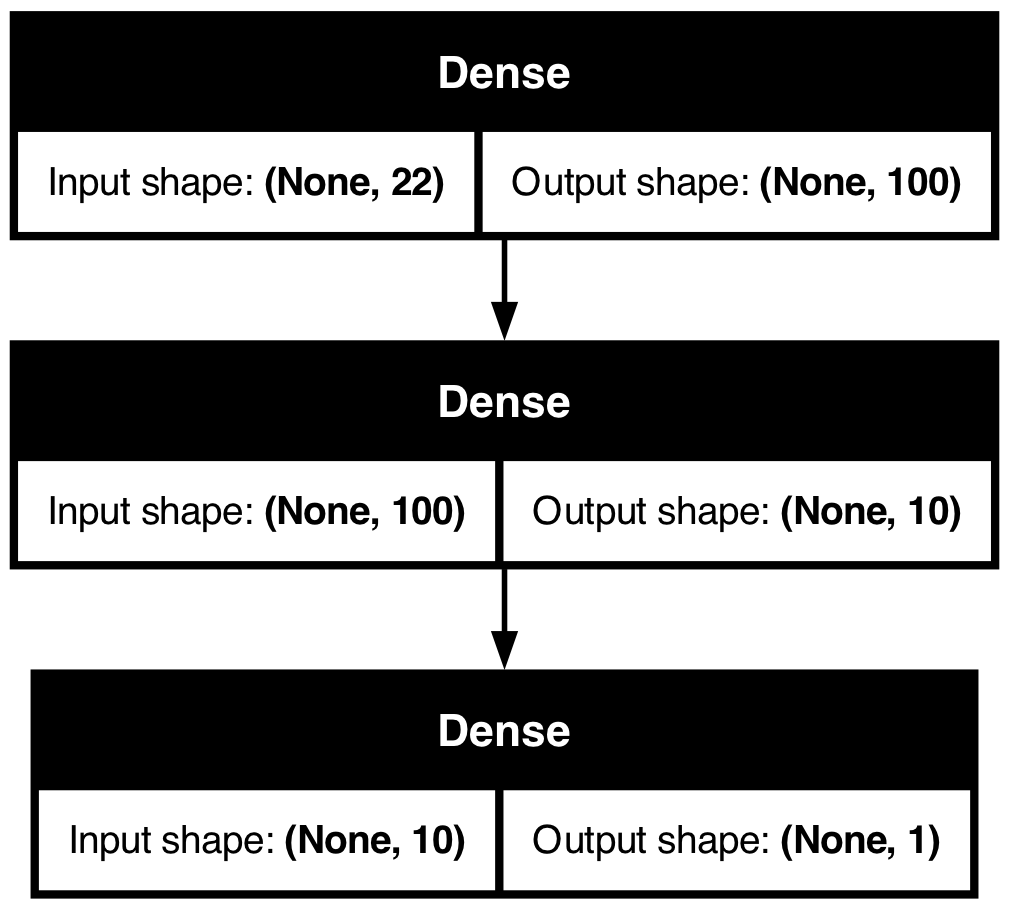

In [99]:
tf.keras.utils.plot_model(best_model, show_shapes=True) 

In [101]:
best_model.evaluate(X_test, y_test) 

 375/9117 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step - loss: 161.8999 - mae: 161.8999

2025-05-06 15:42:30.525274: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 15:42:30.525758: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 421us/step - loss: 161.8198 - mae: 161.8198


[151.03482055664062, 151.03482055664062]

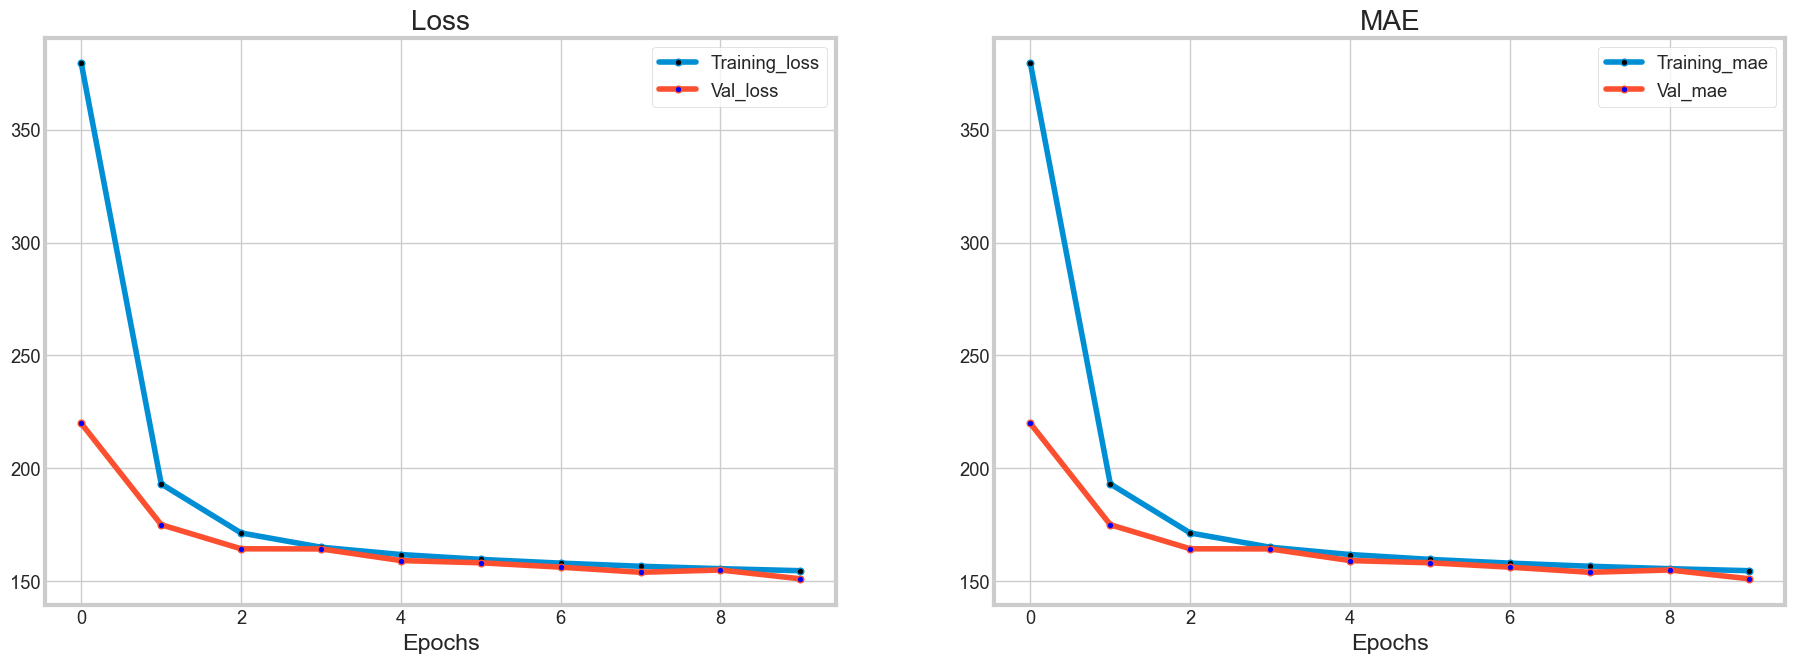

In [102]:
plot_loss_curves(small_model_history)

In [104]:
print("\n=== Layer Weights & Biases ===")
for layer in best_model.layers:
    w, b = layer.get_weights()
    print(f"{layer.name:15s} – weights shape: {w.shape}, biases shape: {b.shape}")



=== Layer Weights & Biases ===
input_1         – weights shape: (22, 100), biases shape: (100,)
input_2         – weights shape: (100, 10), biases shape: (10,)
output_layer    – weights shape: (10, 1), biases shape: (1,)


In [107]:
test_loss, test_mae = best_model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest   –  loss (MAE): {test_loss:.4f},   mae: {test_mae:.4f}")

 359/9117 ━━━━━━━━━━━━━━━━━━━━ 3s 421us/step - loss: 161.3671 - mae: 161.3671

2025-05-06 16:34:48.099664: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 16:34:48.100112: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 424us/step - loss: 161.8198 - mae: 161.8198

Test   –  loss (MAE): 151.0348,   mae: 151.0348


In [116]:
n = 5

#Convert to NumPy arrays if they’re still Tensors
if hasattr(X_test, "numpy"):
    X_test_np = X_test.numpy()
else:
    X_test_np = X_test

if hasattr(y_test, "numpy"):
    y_test_np = y_test.numpy().flatten()
else:
    y_test_np = y_test.flatten()

idx = np.random.choice(len(X_test_np), size=n, replace=False)
x_sample = X_test_np[idx]
y_true   = y_test_np[idx]

#Predict
y_pred = best_model.predict(x_sample).flatten()

df_demo = pd.DataFrame({
    "true": y_true,
    "pred": y_pred,
}, index=idx)

print(f"\n=== Random Prediction Demo (indices {idx.tolist()}) ===")
print(df_demo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

=== Random Prediction Demo (indices [234340, 135277, 262204, 202984, 43734]) ===
          true         pred
234340   869.0   873.475647
135277  1966.0  1971.723022
262204  1544.0  1546.233643
202984  1406.0  1407.905640
43734    702.0   700.339417


2025-05-06 17:03:29.312749: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-06 17:03:29.313161: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

In [85]:
set_seed()
num_features = X_train.shape[1]   

es = EarlyStopping(
    monitor="val_mae",
    patience=3,
    restore_best_weights=True
)

small_model = tf.keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(num_features,), name="dense_1"),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation="relu", name="dense_2"),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(64, activation="relu", name="dense_3"),
    layers.Dense(1, activation="linear", name="output_layer")  
], name="small_model")


small_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)


small_model_history = small_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[es]
)

Epoch 1/10


2025-05-06 01:56:16.111993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 01:56:16.112441: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36447/36465 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 338.5373 - mae: 338.5373

2025-05-06 01:56:56.166790: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 01:56:56.167157: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36465/36465 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step - loss: 338.5032 - mae: 338.5032 - val_loss: 208.9808 - val_mae: 208.9808
Epoch 2/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 219.0523 - mae: 219.0523 - val_loss: 175.1327 - val_mae: 175.1327
Epoch 3/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - loss: 204.2547 - mae: 204.2547 - val_loss: 183.9113 - val_mae: 183.9113
Epoch 4/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step - loss: 196.2590 - mae: 196.2590 - val_loss: 159.7493 - val_mae: 159.7493
Epoch 5/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 189.4955 - mae: 189.4955 - val_loss: 162.4722 - val_mae: 162.4722
Epoch 6/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 185.7480 - mae: 185.7480 - val_loss: 164.6401 - val_mae: 164.6401
Epoch 7/10
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 183.0461 - mae: 183.0461 - val_loss: 180.1926 - val_mae: 180.1926


In [62]:
small_model.summary()


Model: "small_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,853 (558.02 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 94,724 (370.02 KB)

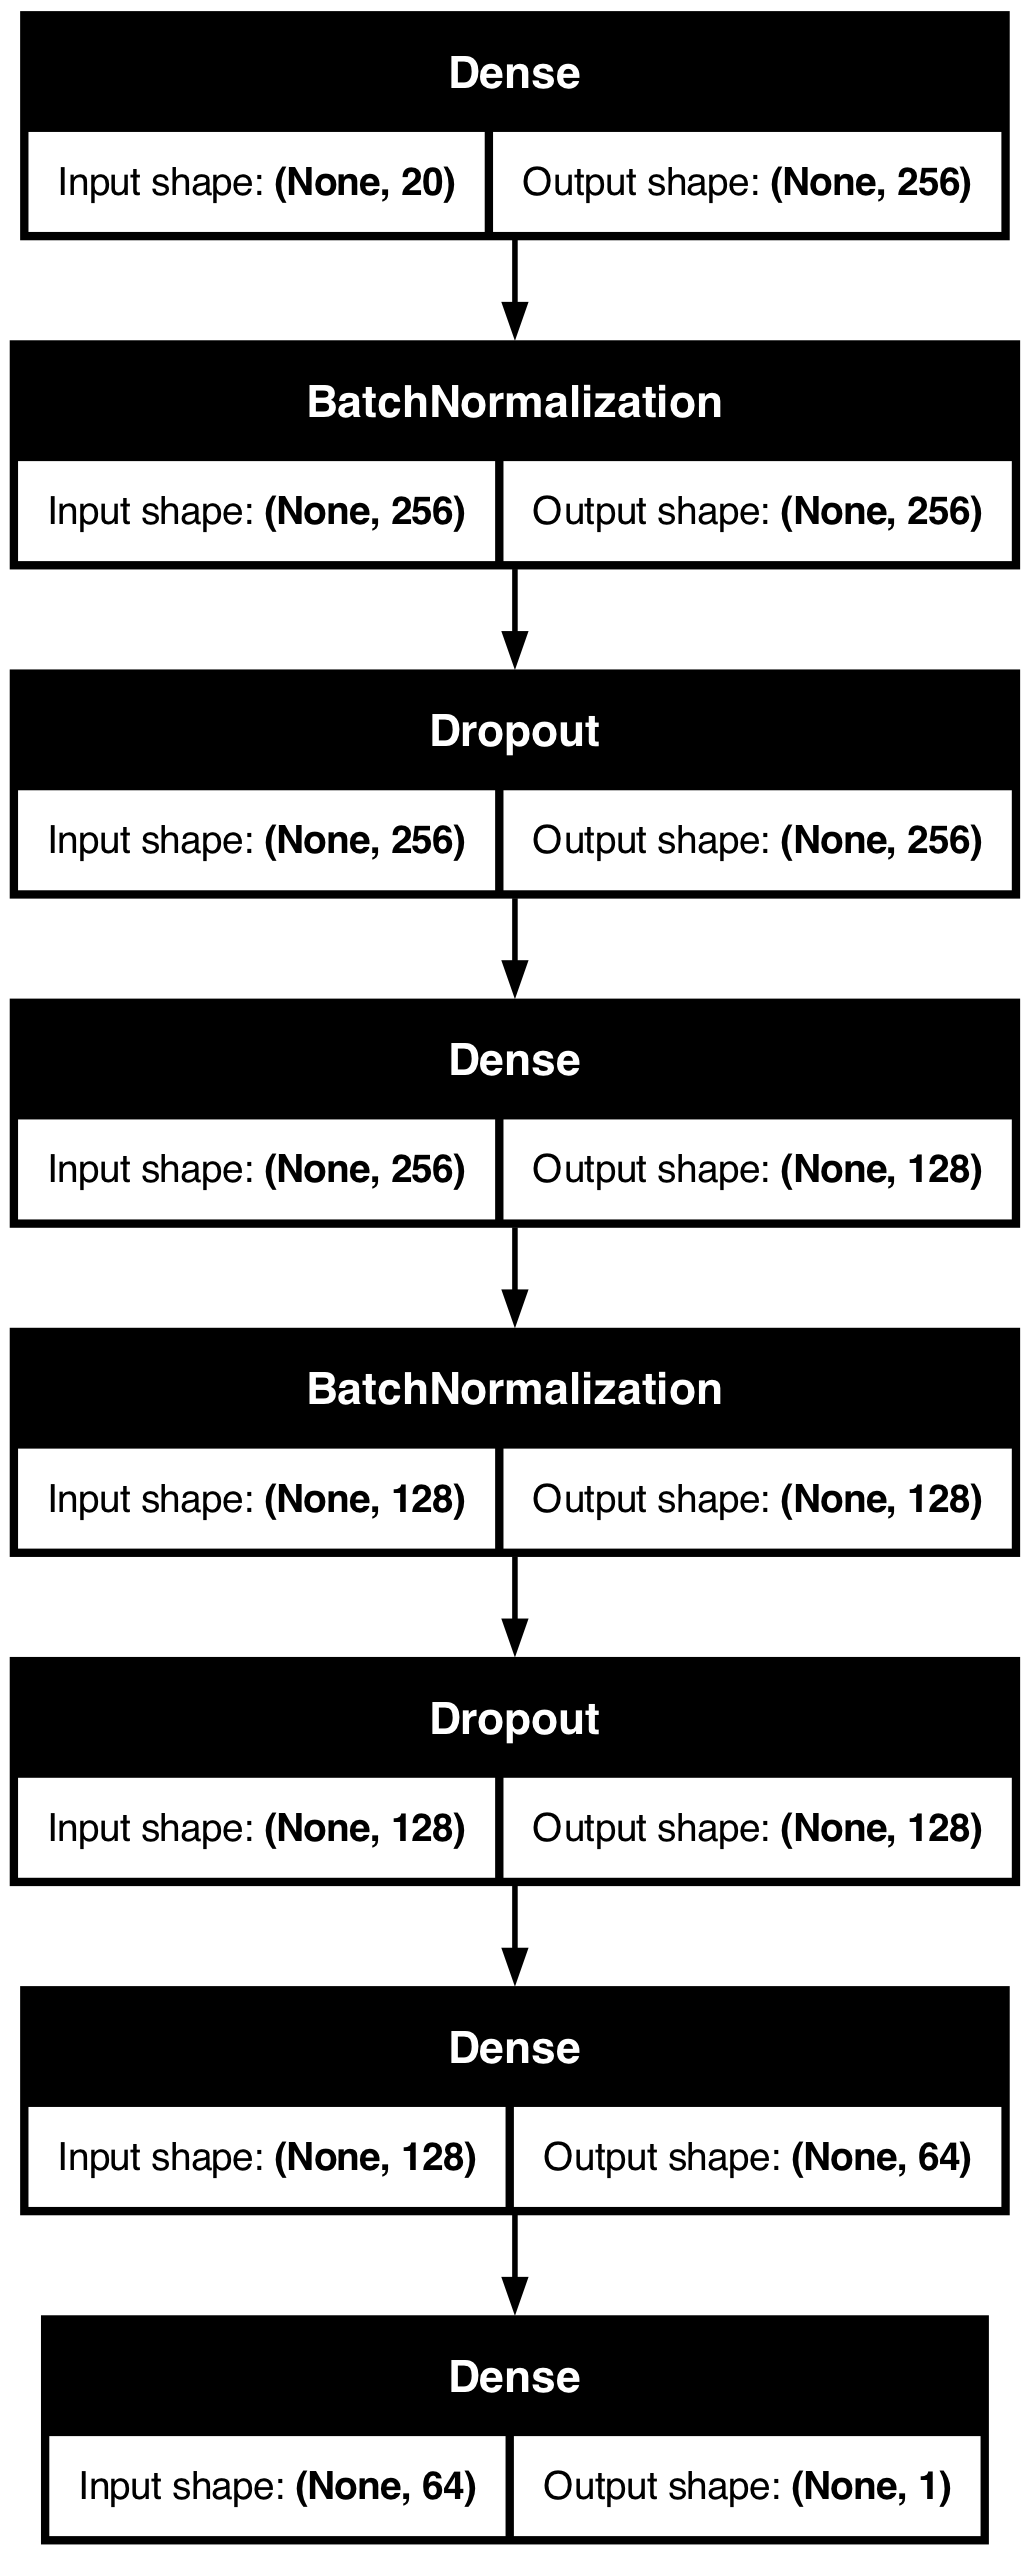

In [ ]:
tf.keras.utils.plot_model(small_model, show_shapes=True) 

In [100]:

def plot_loss_curves(history):
    """
    Returns separate loss curves for
    training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    

    epochs = range(len(history.history["loss"]))
    

    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="Training_loss", marker="o", markerfacecolor="k")
    plt.plot(epochs, val_loss, label="Val_loss", marker="o", markerfacecolor="b")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    

    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, label="Training_mae", marker="o", markerfacecolor="k")
    plt.plot(epochs, val_mae, label="Val_mae", marker="o", markerfacecolor="b")
    plt.title("MAE")
    plt.xlabel("Epochs")
    plt.legend();

In [ ]:
small_model.evaluate(X_test, y_test) 

 271/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 560us/step - loss: 206.0193 - mae: 206.0193

2025-05-05 22:10:30.285379: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-05 22:10:30.285824: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 5s 534us/step - loss: 210.6786 - mae: 210.6786


[200.4701690673828, 200.4701690673828]

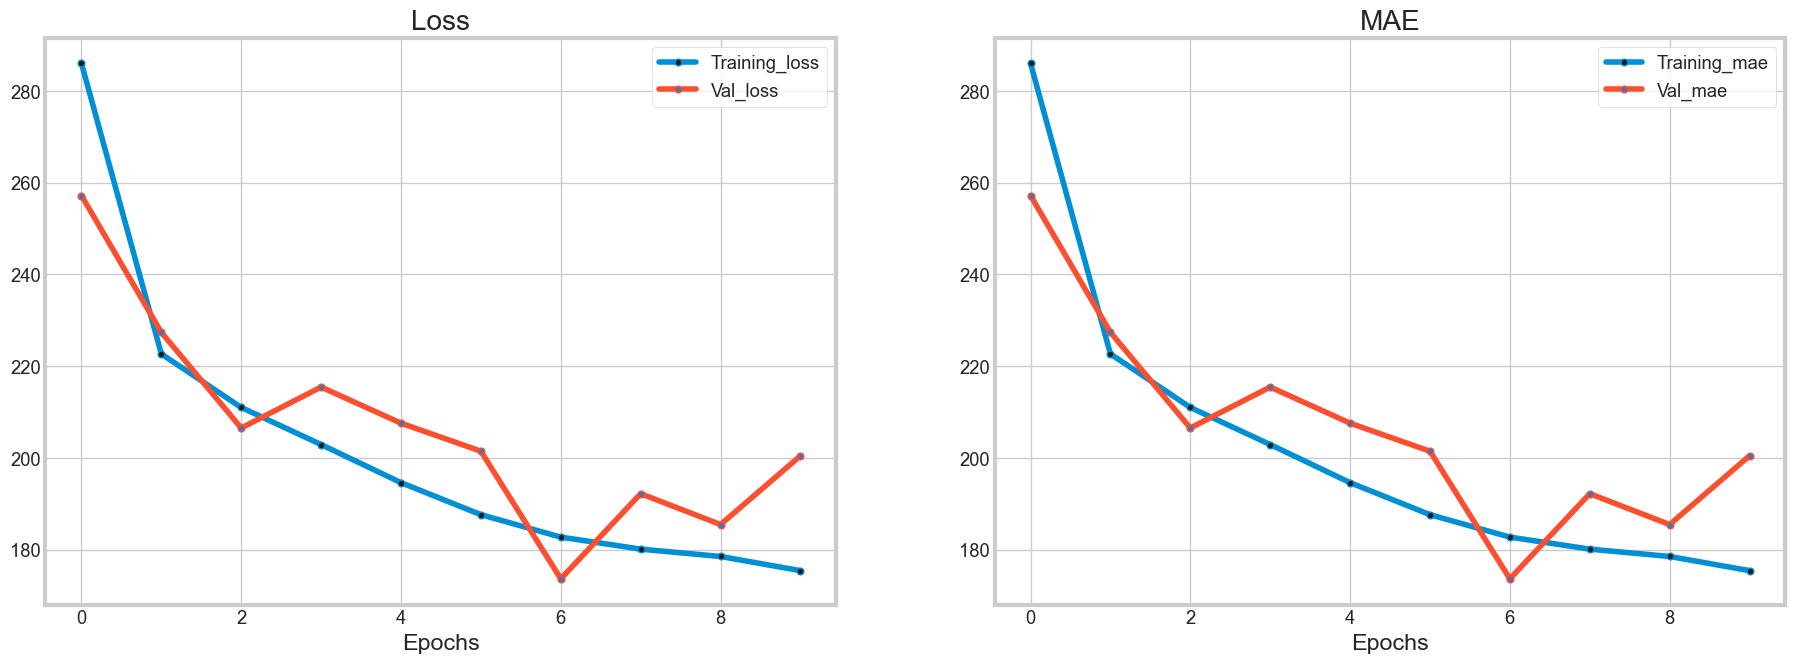

In [66]:
plot_loss_curves(small_model_history)

In [86]:

set_seed()
num_features = X_train.shape[1]   

es = EarlyStopping(
    monitor="val_mae",
    patience=3,
    restore_best_weights=True
)


small_model2 = tf.keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(num_features,), name="dense_1"),
    layers.BatchNormalization(),
    layers.Dropout(0.05),
    layers.Dense(128, activation="relu", name="dense_2"),
    layers.BatchNormalization(),
    layers.Dropout(0.05),
    layers.Dense(64, activation="relu", name="dense_3"),
    layers.Dense(1, activation="linear", name="output_layer") 
], name="small_model2")

small_model2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)


small_model2_history = small_model2.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=15,
    callbacks=[es]
)

Epoch 1/15


2025-05-06 02:00:56.805941: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:00:56.806362: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36444/36465 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 329.3490 - mae: 329.3490

2025-05-06 02:01:42.265204: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:01:42.265774: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36465/36465 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step - loss: 329.3080 - mae: 329.3080 - val_loss: 214.2420 - val_mae: 214.2420
Epoch 2/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 208.1297 - mae: 208.1297 - val_loss: 223.3012 - val_mae: 223.3012
Epoch 3/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - loss: 191.7740 - mae: 191.7740 - val_loss: 186.6300 - val_mae: 186.6300
Epoch 4/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - loss: 183.5146 - mae: 183.5146 - val_loss: 166.7732 - val_mae: 166.7732
Epoch 5/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 43s 1ms/step - loss: 179.8989 - mae: 179.8989 - val_loss: 169.2545 - val_mae: 169.2545
Epoch 6/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - loss: 175.7733 - mae: 175.7733 - val_loss: 171.3080 - val_mae: 171.3080
Epoch 7/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step - loss: 174.2209 - mae: 174.2209 - val_loss: 160.0872 - val_mae: 160.0872
Epoch 8/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - loss: 172.4000 - mae: 172.4000 - va

In [ ]:
small_model2.summary()

Model: "small_model2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,853 (558.02 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 94,724 (370.02 KB)

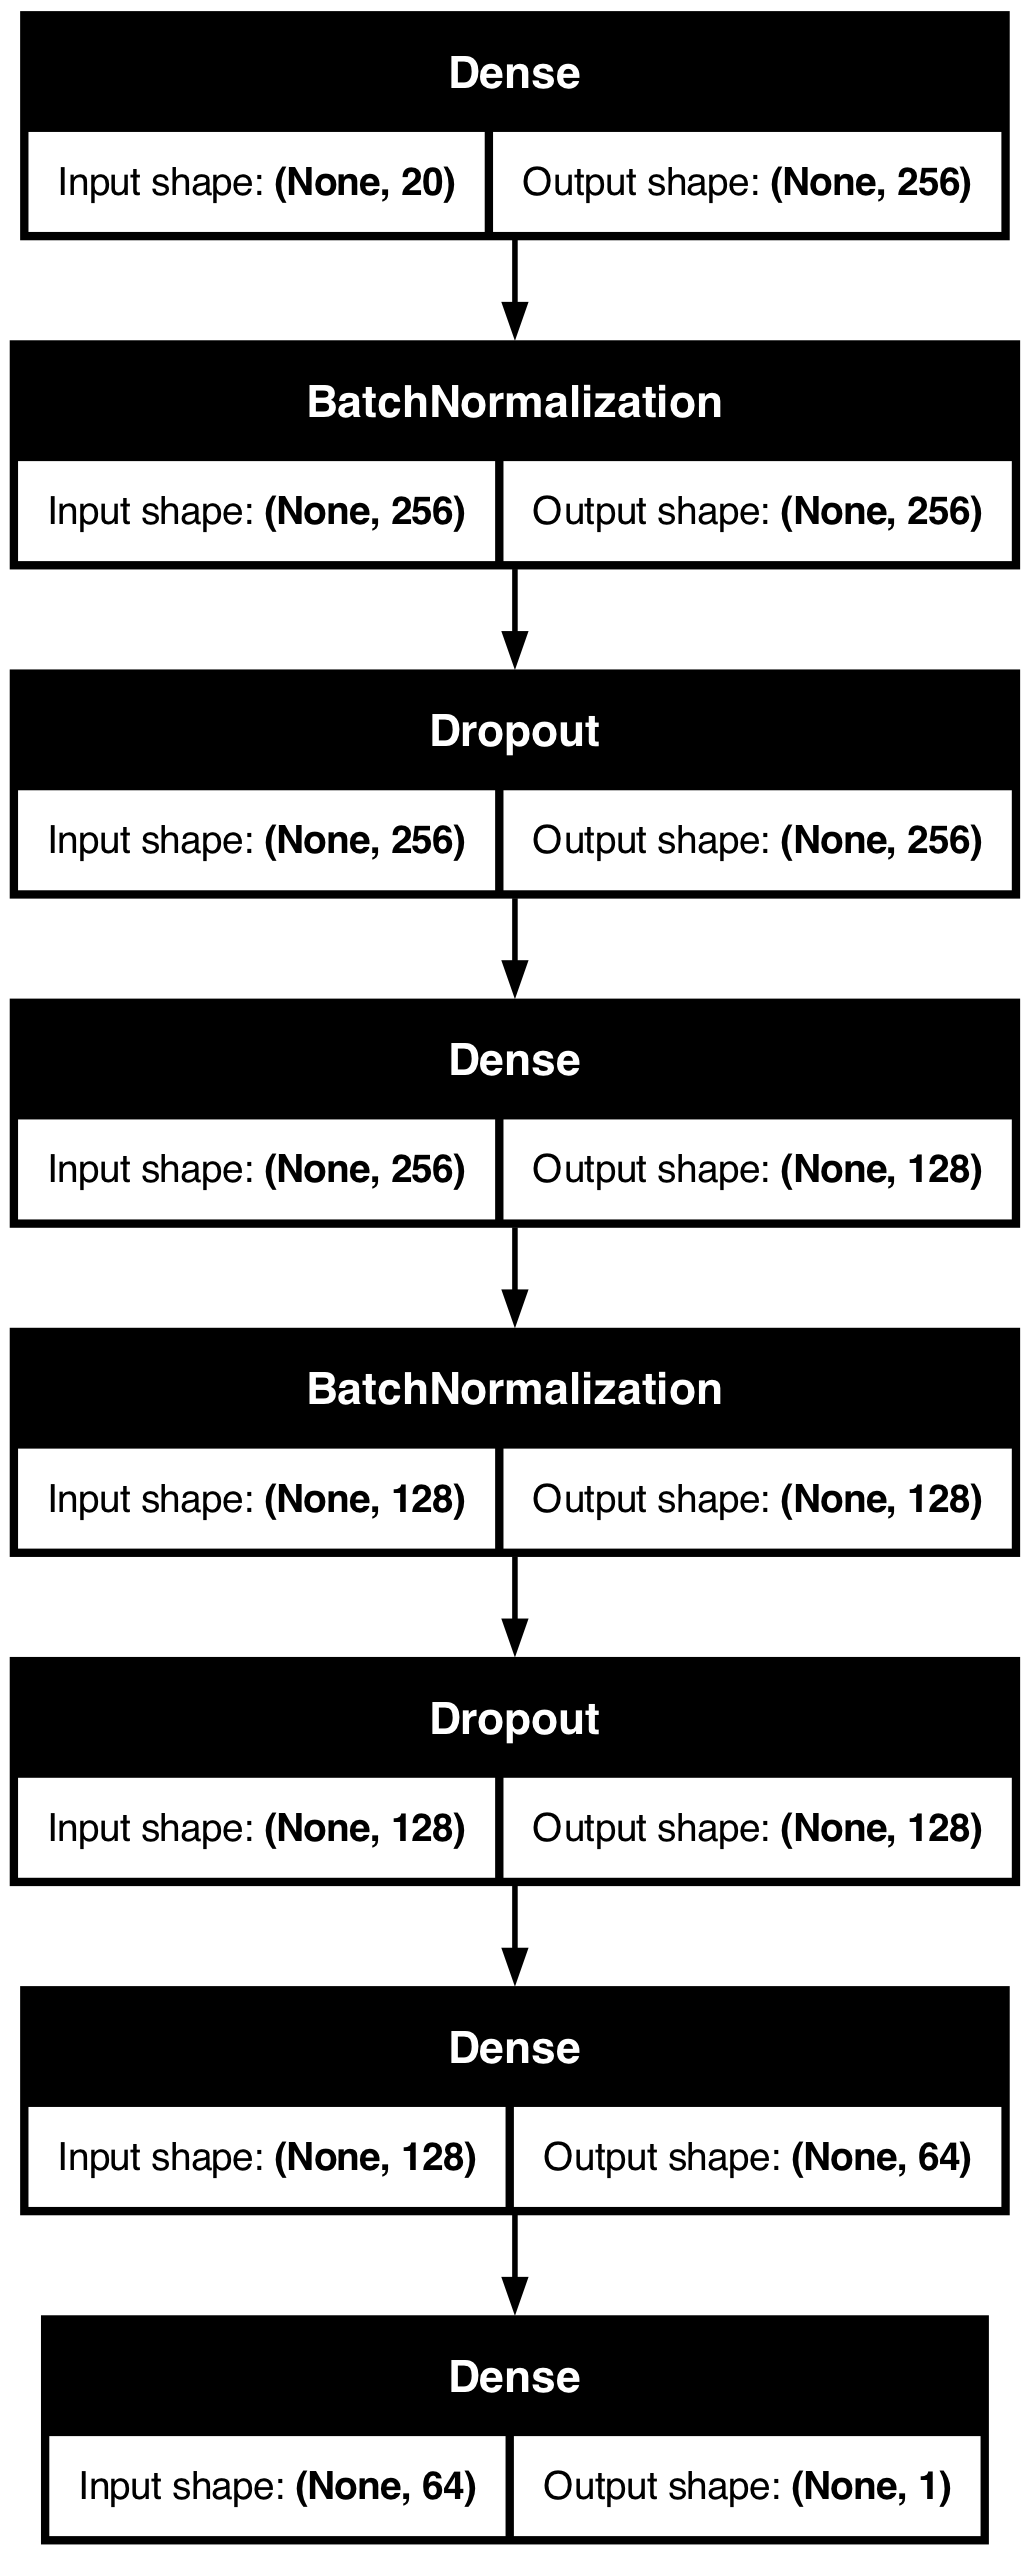

In [ ]:
tf.keras.utils.plot_model(small_model2, show_shapes=True)

In [ ]:
small_model2.evaluate(X_test, y_test)

 293/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 516us/step - loss: 186.4574 - mae: 186.4574

2025-05-05 22:24:04.010147: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-05 22:24:04.010639: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 5s 520us/step - loss: 191.1148 - mae: 191.1148


[179.8707275390625, 179.8707275390625]

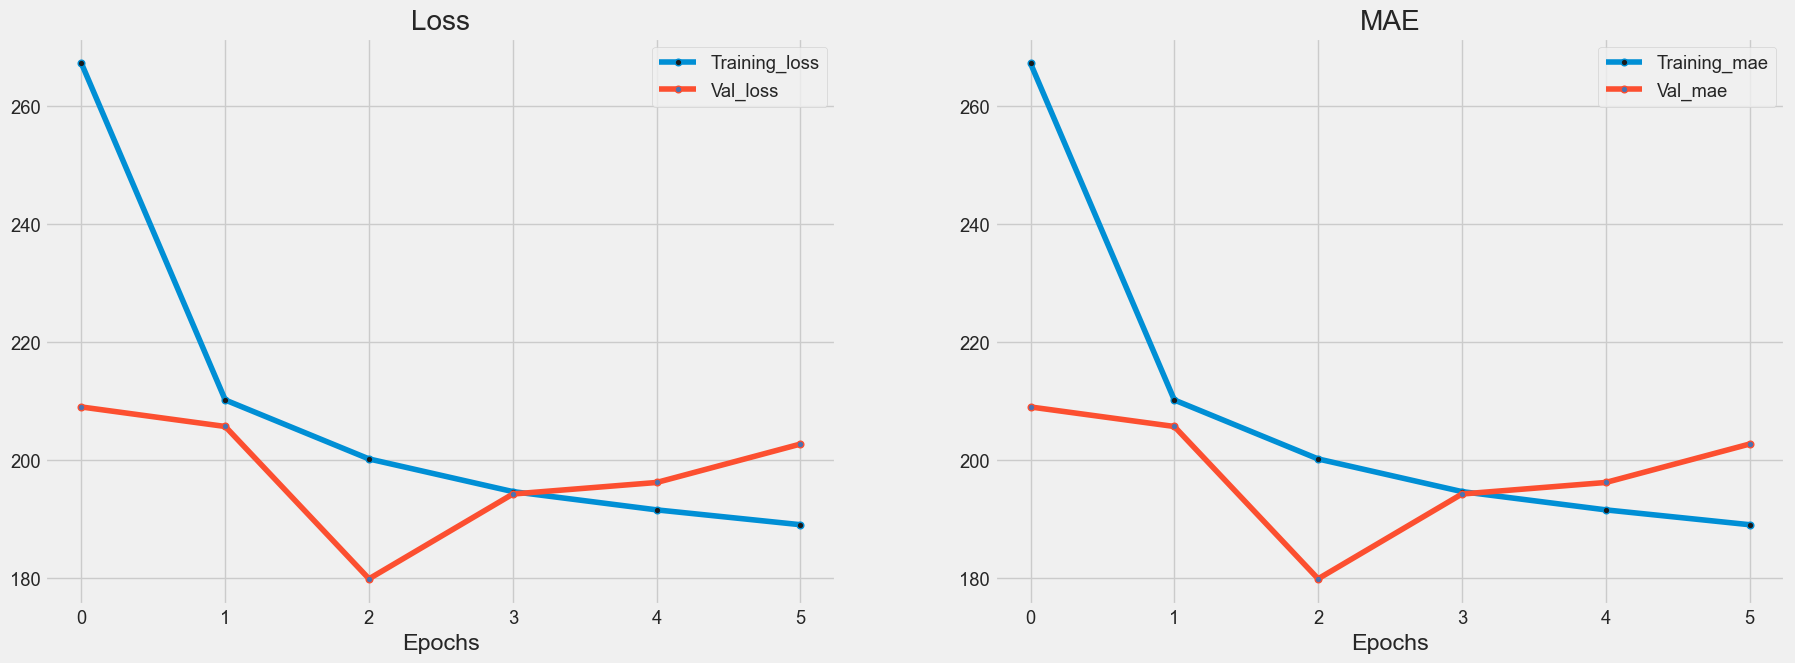

In [72]:
plot_loss_curves(small_model2_history)

In [87]:

set_seed()
num_features = X_train.shape[1]   

es = EarlyStopping(
    monitor="val_mae",
    patience=3,
    restore_best_weights=True
)


small_model3 = Sequential([
    layers.Dense(128, activation="relu",
                 input_shape=(num_features,),
                 kernel_regularizer=regularizers.L2(1e-4),
                 name="dense_1"),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.L2(1e-4),
                 name="dense_2"),
    layers.BatchNormalization(),
    layers.Dropout(0.05),
    layers.Dense(32, activation="relu",
                 kernel_regularizer=regularizers.L2(1e-4),
                 name="dense_3"),
    layers.Dense(1, name="output_layer")
], name="small_model3")


small_model3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)


small_model3_history = small_model3.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=15,
    callbacks=[es]
)

Epoch 1/15


2025-05-06 02:08:07.083462: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:08:07.083932: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36416/36465 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 346.7290 - mae: 346.5541

2025-05-06 02:08:36.117417: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:08:36.117813: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36465/36465 ━━━━━━━━━━━━━━━━━━━━ 33s 882us/step - loss: 346.6246 - mae: 346.4497 - val_loss: 238.6829 - val_mae: 238.4062
Epoch 2/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 31s 842us/step - loss: 210.3618 - mae: 210.0718 - val_loss: 211.4068 - val_mae: 211.0818
Epoch 3/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 29s 799us/step - loss: 193.0496 - mae: 192.7137 - val_loss: 187.0792 - val_mae: 186.7122
Epoch 4/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 29s 798us/step - loss: 185.6370 - mae: 185.2605 - val_loss: 171.0693 - val_mae: 170.6685
Epoch 5/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 30s 812us/step - loss: 181.0024 - mae: 180.5925 - val_loss: 179.2622 - val_mae: 178.8336
Epoch 6/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 29s 784us/step - loss: 177.7354 - mae: 177.3002 - val_loss: 176.6720 - val_mae: 176.2217
Epoch 7/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 28s 781us/step - loss: 175.3587 - mae: 174.9034 - val_loss: 179.1109 - val_mae: 178.6399


In [ ]:
small_model3.summary() 

Model: "small_model3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 26,884 (105.02 KB)

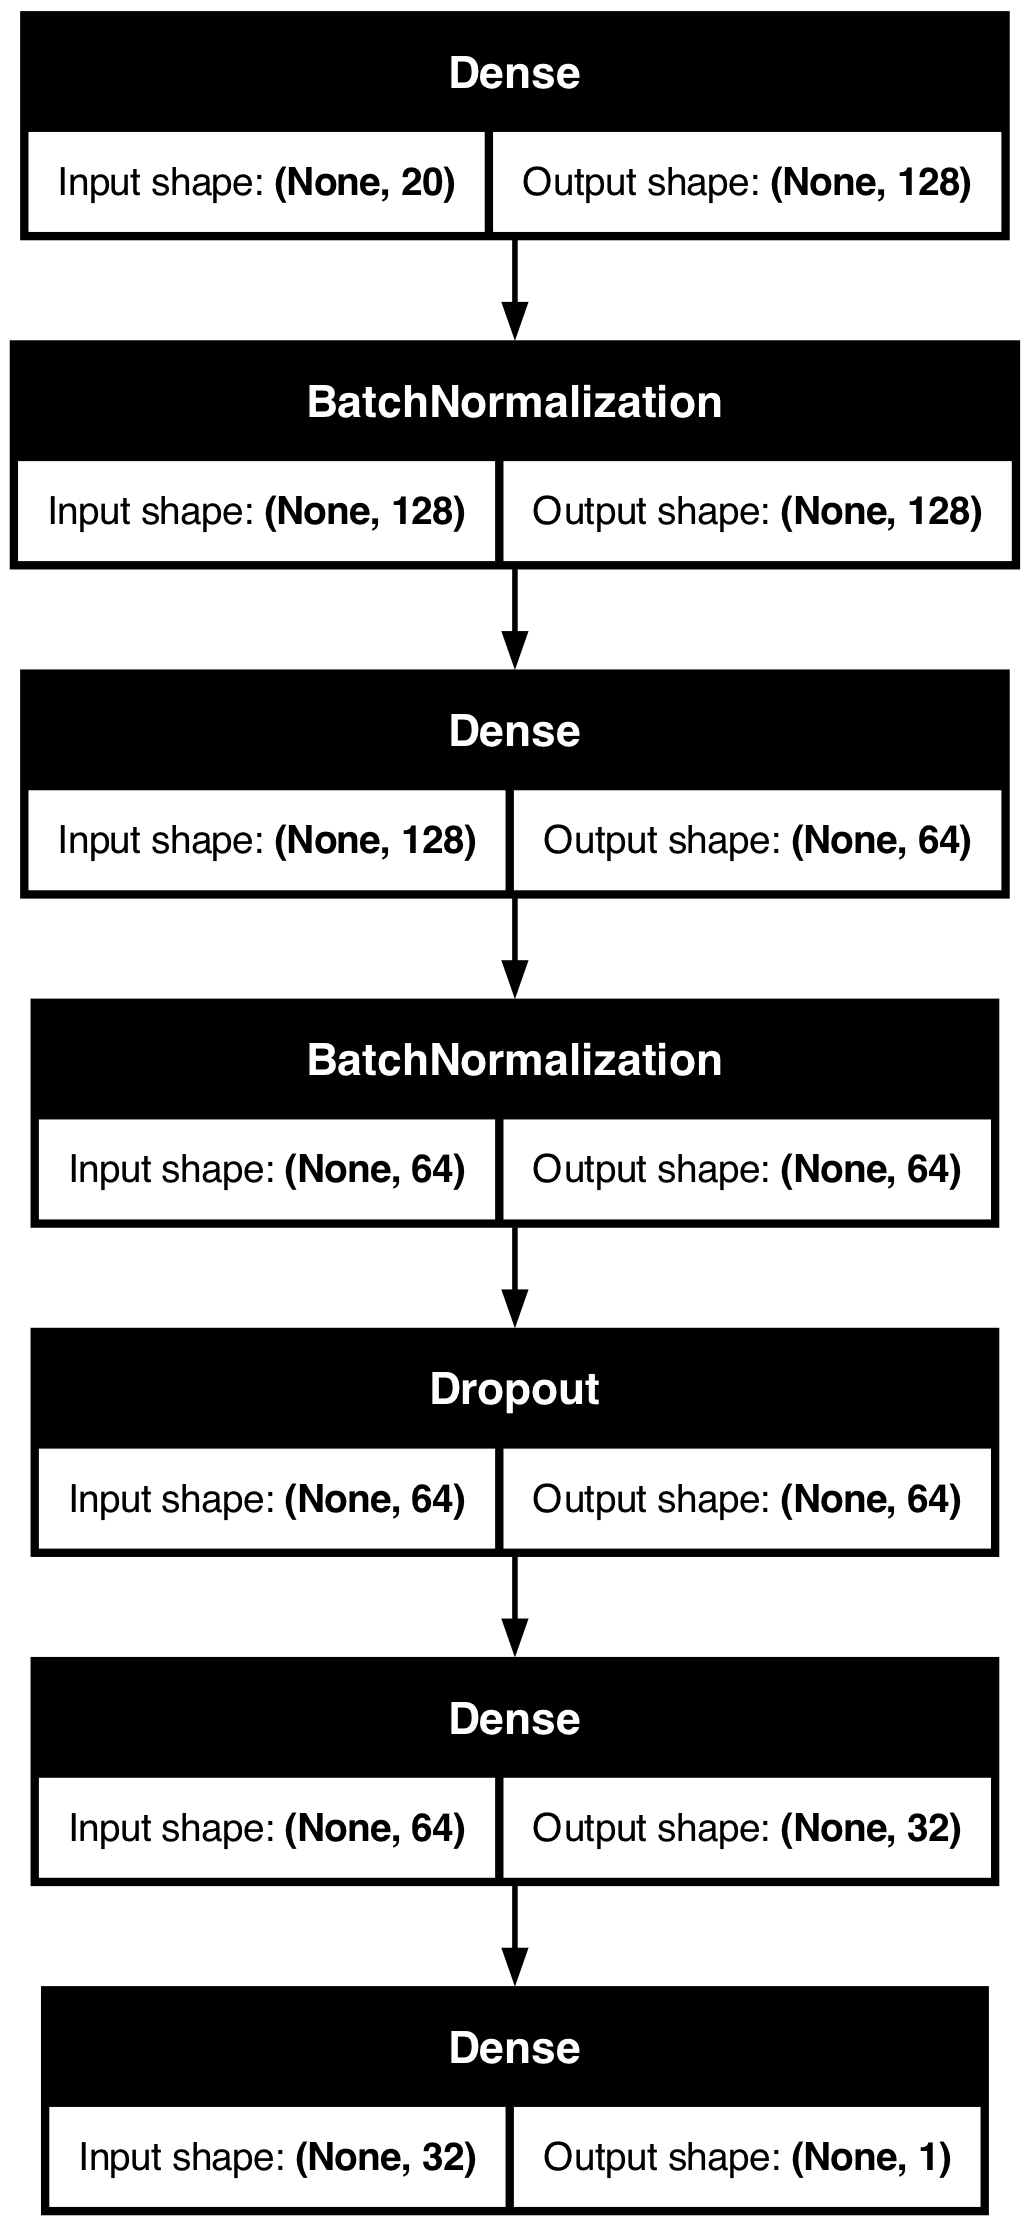

In [ ]:
tf.keras.utils.plot_model(small_model3, show_shapes=True) 

In [ ]:
small_model3.evaluate(X_test, y_test)

 315/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 479us/step - loss: 178.1739 - mae: 177.7634

2025-05-05 22:50:25.334081: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-05 22:50:25.334465: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 5s 498us/step - loss: 179.3891 - mae: 178.9788


[169.00115966796875, 168.59107971191406]

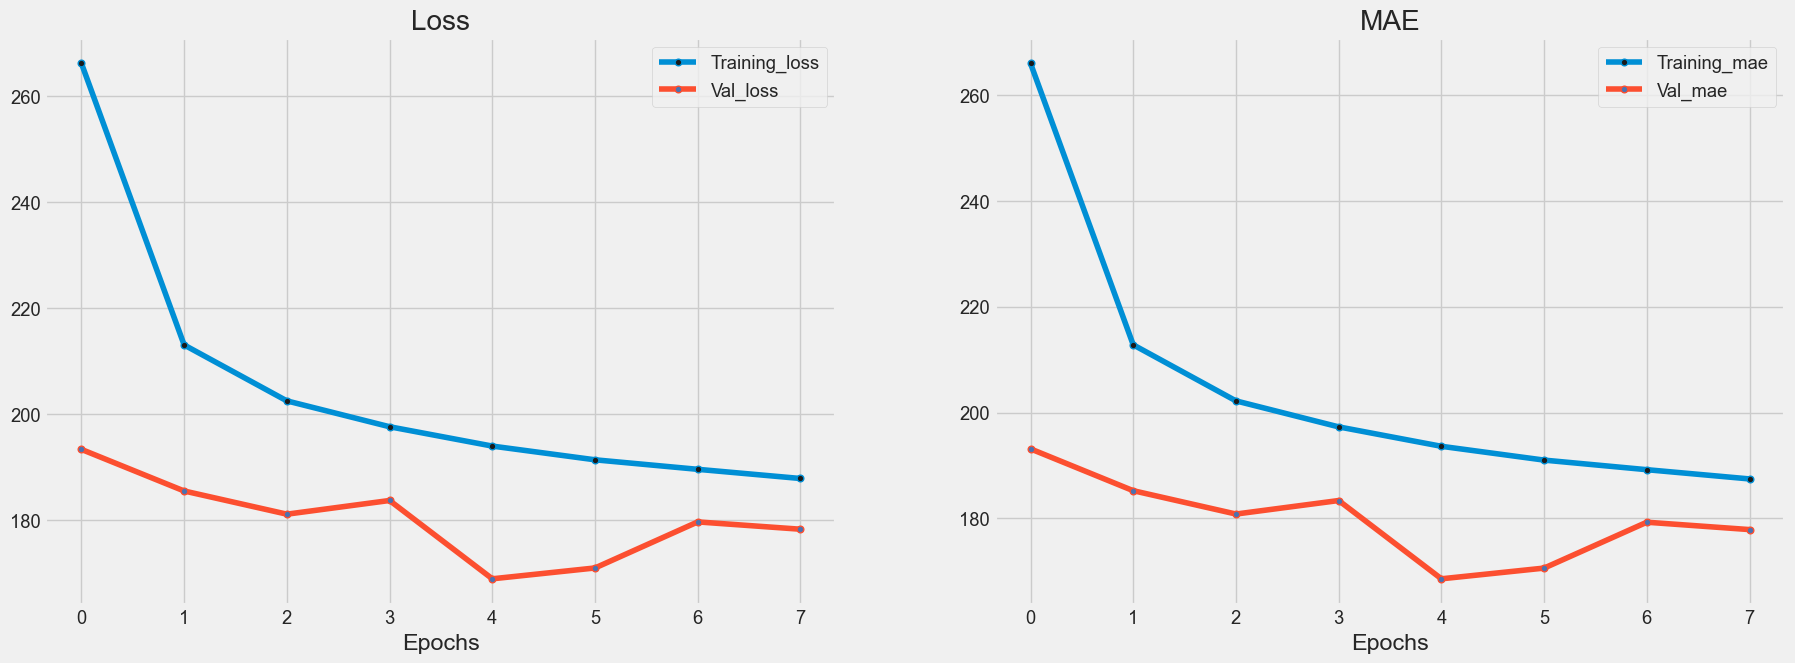

In [84]:
plot_loss_curves(small_model3_history)

In [88]:

set_seed()
num_features = X_train.shape[1]   

es = EarlyStopping(
    monitor="val_mae",
    patience=3,
    restore_best_weights=True
)


small_model4 = Sequential([
    layers.Dense(128, activation="relu",
                 input_shape=(num_features,),
                 kernel_regularizer=regularizers.L2(1e-3),
                 name="dense_1"),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.L2(1e-3),
                 name="dense_2"),
    layers.BatchNormalization(),
    layers.Dense(32, activation="relu",
                 kernel_regularizer=regularizers.L2(1e-3),
                 name="dense_3"),
    layers.Dense(1, name="output_layer")
], name="small_model4")


small_model4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)


small_model4_history = small_model4.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=15,
    callbacks=[es]
)

Epoch 1/15


2025-05-06 02:11:35.930402: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:11:35.930831: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36445/36465 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 334.6913 - mae: 332.8842

2025-05-06 02:12:03.035367: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-06 02:12:03.035762: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

36465/36465 ━━━━━━━━━━━━━━━━━━━━ 31s 833us/step - loss: 334.6453 - mae: 332.8379 - val_loss: 229.9444 - val_mae: 227.2377
Epoch 2/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 31s 846us/step - loss: 196.6735 - mae: 193.9050 - val_loss: 172.1337 - val_mae: 169.1789
Epoch 3/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 30s 825us/step - loss: 183.0246 - mae: 180.0153 - val_loss: 179.5339 - val_mae: 176.3882
Epoch 4/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 31s 847us/step - loss: 175.8224 - mae: 172.6275 - val_loss: 189.1374 - val_mae: 185.8431
Epoch 5/15
36465/36465 ━━━━━━━━━━━━━━━━━━━━ 29s 797us/step - loss: 170.9517 - mae: 167.6270 - val_loss: 174.0618 - val_mae: 170.6615


In [ ]:
small_model4.summary()

Model: "small_model4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,709 (159.02 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 26,884 (105.02 KB)

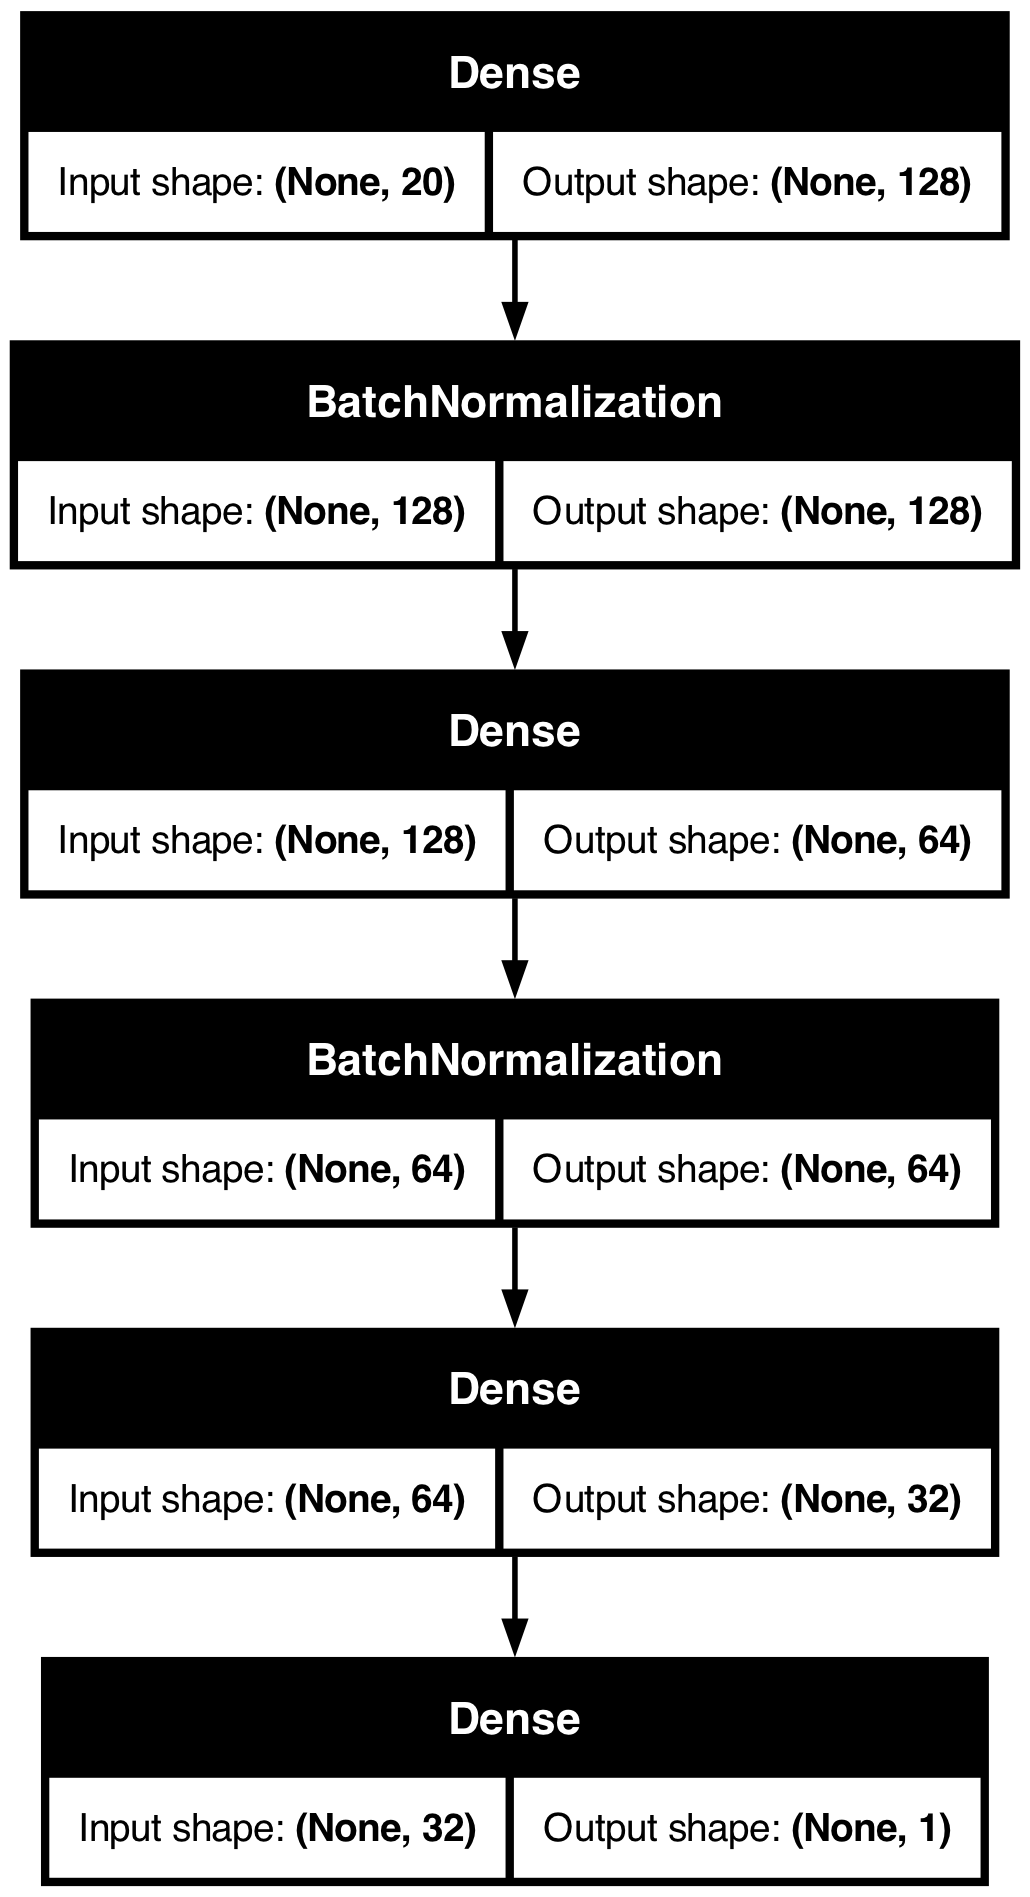

In [ ]:
tf.keras.utils.plot_model(small_model4, show_shapes=True)

In [ ]:
small_model4.evaluate(X_test, y_test) 

 323/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 468us/step - loss: 177.0106 - mae: 174.5488

2025-05-05 23:14:04.171466: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-05 23:14:04.171844: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

9117/9117 ━━━━━━━━━━━━━━━━━━━━ 4s 464us/step - loss: 177.9267 - mae: 175.4652


[166.98768615722656, 164.52610778808594]

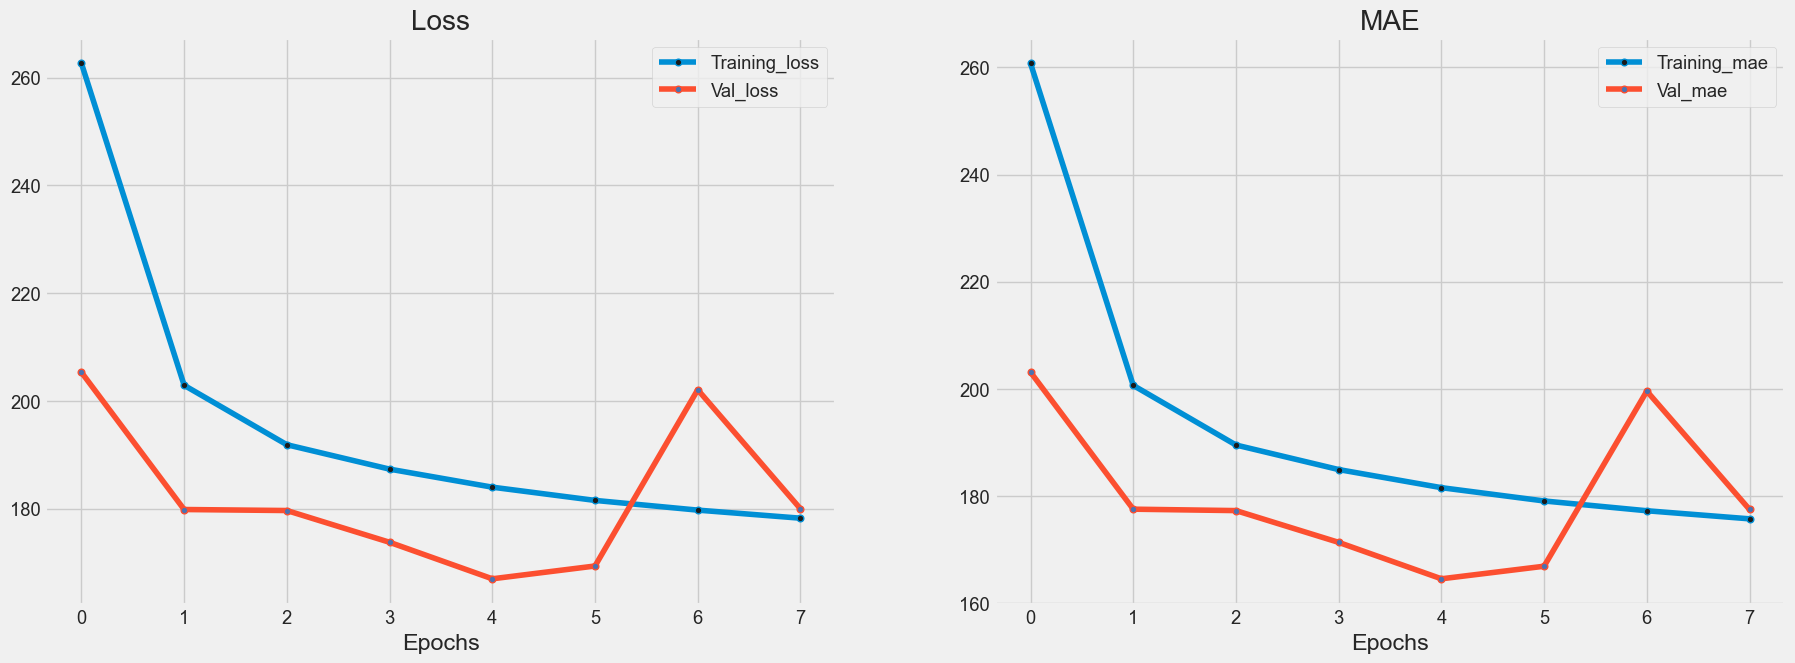

In [ ]:
plot_loss_curves(small_model4_history)

# Different Regression Models

In [89]:
from sklearn.linear_model      import LinearRegression
from sklearn.tree              import DecisionTreeRegressor
from sklearn.ensemble          import GradientBoostingRegressor, RandomForestRegressor
from xgboost                    import XGBRegressor
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [90]:
X_train_np = X_train.numpy()
X_test_np  = X_test.numpy()
y_train_np = y_train.numpy()
y_test_np  = y_test.numpy()

# Radomized SearchCV

In [ ]:
dt_params = {
    "max_depth":         [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4]
}

rf_params = {
    "n_estimators":      [50, 100, 200],
    "max_depth":         [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf":  [1, 2],
    "max_features":      ["sqrt", "auto"]
}

gb_params = {
    "n_estimators":   [100, 200],
    "learning_rate":  [0.01, 0.05, 0.1],
    "max_depth":      [3, 5],
    "subsample":      [0.8, 1.0]
}

xgb_params = {
    "n_estimators":       [100, 200],
    "learning_rate":      [0.01, 0.1],
    "max_depth":          [3, 6],
    "subsample":          [0.8, 1.0],
    "colsample_bytree":   [0.8, 1.0]
}

In [92]:
searches = [
    ("Decision Tree",    DecisionTreeRegressor(random_state=42), dt_params, 10),
    ("Random Forest",    RandomForestRegressor(random_state=42), rf_params, 15),
    ("Gradient Boosting",GradientBoostingRegressor(random_state=42), gb_params, 15),
    ("XGBoost",          XGBRegressor(objective="reg:squarederror", random_state=42), xgb_params, 15),
]

In [ ]:
for name, estimator, params, n_iter in searches:
    print(f"\n>>> Tuning {name} (n_iter={n_iter})")
    search = RandomizedSearchCV(
        estimator,
        param_distributions=params,
        n_iter=n_iter,
        cv=3,                        
        scoring="neg_mean_absolute_error",
        n_jobs=1,                    
        random_state=42,
        verbose=1
    )
    search.fit(X_train_np, y_train_np) 
    best = search.best_estimator_
    
    cv_mae = -search.best_score_
    test_preds = best.predict(X_test_np)
    test_mae = mean_absolute_error(y_test_np, test_preds)
    
    print(f"Best {name} params: {search.best_params_}")
    print(f"{name} CV MAE:  {cv_mae:.2f}")
    print(f"{name} Test MAE: {test_mae:.2f}")


>>> Tuning Decision Tree (n_iter=10)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': [None, 5, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Best Decision Tree params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
Decision Tree CV MAE:  416.85
Decision Tree Test MAE: 411.48

>>> Tuning Random Forest (n_iter=15)
Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=15, n_jobs=1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'auto'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Best Random Forest params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Random Forest CV MAE:  378.91
Random Forest Test MAE: 370.78

>>> Tuning Gradient Boosting (n_iter=15)
Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=15, n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Best Gradient Boosting params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Gradient Boosting CV MAE:  366.37
Gradient Boosting Test MAE: 367.12

>>> Tuning XGBoost (n_iter=15)
Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=15, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 6],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

Best XGBoost params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost CV MAE:  302.15
XGBoost Test MAE: 285.03
